In [2388]:
from urllib import request as ur
from bs4 import BeautifulSoup as bs
import re

from imdb import IMDb

from math import ceil
from numpy import inf, nan, median, array, sum
from scipy.stats import chi2_contingency

import ast

import time

import pandas as pd
from json import loads
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor, plot_tree

### Get movie database from YIFY site

In [16]:
first_page_url = 'https://yts.mx/api/v2/list_movies.json?limit=50&page=1'
request_with_ua = ur.Request(first_page_url, headers = {'User-Agent': 'some_user_agent'}) # have to set ua to not get error 403
data = loads(ur.urlopen(request_with_ua).read()) # parse result as JSON object

In [31]:
num_movies = data['data']['movie_count']
print('# of movies currently in YIFY database:', num_movies)

num_go_through = ceil(data['data']['movie_count'] / 50)
print('# of 50-result pages to scrape through:', num_go_through)

# of movies currently in YIFY database: 20458
# of 50-result pages to scrape through: 410


In [35]:
links = ['https://yts.mx/api/v2/list_movies.json?limit=50&page=' + str(i) for i in range(1, num_go_through + 1)]
links[:5]

['https://yts.mx/api/v2/list_movies.json?limit=50&page=1',
 'https://yts.mx/api/v2/list_movies.json?limit=50&page=2',
 'https://yts.mx/api/v2/list_movies.json?limit=50&page=3',
 'https://yts.mx/api/v2/list_movies.json?limit=50&page=4',
 'https://yts.mx/api/v2/list_movies.json?limit=50&page=5']

Parse first page, then go through all links

In [49]:
dt = pd.json_normalize(data['data']['movies'])
dt = dt[['title', 'year', 'runtime', 'rating', 'genres', 'summary', 'language', 'imdb_code']]
dt.head()

,title,year,runtime,rating,genres,summary,language,imdb_code
0,Go-Go Sisters,2018,118,7.4,"[Comedy, Drama]",Go-go sisters brings together two parallel sto...,vi,tt8081638
1,Chi Pheo Ngoai Truyen,2017,95,5.4,[Comedy],,vi,tt6947052
2,Husband Swap,2018,0,6.0,"[Drama, Romance]",,vi,tt9020602
3,Than Tuong,2013,113,7.2,"[Comedy, Drama, Romance]",Tri (Harry Lu) is the only son in a prestigiou...,vi,tt5231420
4,The Girl from Yesterday,2017,120,7.2,"[Comedy, Romance]",A teenage boy causes problems on an everyday b...,vi,tt7194618


Parse all data into one dataframe

In [50]:
def parse_urls(url):
    
    request_with_ua = ur.Request(url, headers = {'User-Agent': 'some_user_agent'}) # have to set ua to not get error 403
    data = loads(ur.urlopen(request_with_ua).read()) # parse result as JSON object
    
    dt = pd.json_normalize(data['data']['movies'])
    dt = dt[['title', 'year', 'runtime', 'rating', 'genres', 'summary', 'language', 'imdb_code']]
    
    return dt    

In [54]:
data = pd.concat([parse_urls(url) for url in links])

In [59]:
data.to_csv('movies.csv', index = False)

Put data in necessary format

In [63]:
data.dtypes # all good

title         object
year           int64
runtime        int64
rating       float64
genres        object
summary       object
language      object
imdb_code     object
dtype: object

### Enhance with data from IMDb (budget, BO opening weekend)

Will build scraper by checking results on the 'Dark Knight' web page

In [66]:
data[data['imdb_code'] == 'tt0468569']

,title,year,runtime,rating,genres,summary,language,imdb_code
30,The Dark Knight,2008,152,9.0,"[Action, Adventure, Crime, Drama, Thriller]",Set within a year after the events of Batman B...,en,tt0468569


In [77]:
imdb_code = 'tt0468569'
imdb_url = 'https://www.imdb.com/title/' + imdb_code + '/'

request = ur.Request(imdb_url,headers={'User-Agent': 'some_user_agent'})
html = ur.urlopen(request).read()
soup = bs(html, 'html.parser')
details = soup.find_all('div', {'class': ['article'], 'id' : ['titleDetails']})

Parsing through this HTML code would be the next step, but Python has an IMDb package which only needs one argument (movie id) and spits back everything

In [292]:
def get_imdb_data(imdb_code):
    
    imdb_code = re.sub('[^0-9]', '', imdb_code) # IMDb() needs the movie ID to be only the numeric part
    get_data = IMDb().get_movie(imdb_code)
    
    if ('cast' in get_data.data.keys()) is True:
        lead_actors = [people['name'] for people in get_data.data['cast'][:3]]
    else:
        lead_actors = float('nan')
    
    if ('directors' in get_data.data.keys()) is True:
        directors = [directors['name'] for directors in get_data.data['directors'][:2]]
    else:
        directors = float('nan')
        
    if ('writer' in get_data.data.keys()) is True:
        writers = [writers['name'] for writers in get_data.data['writer'][:2]]
    else:
        writers = float('nan')
    
    if ('box office' in get_data.data.keys()) is True:
        #budget, opening_we, ww_sum = re.sub('[^0-9.]','', get_data.data['box office']['Budget'].split()[0]), re.sub('[^0-9.]','', get_data.data['box office']['Opening Weekend United States'].split()[0]), re.sub('[^0-9.]','', get_data.data['box office']['Cumulative Worldwide Gross'].split()[0])
        financials = get_data.data['box office']
    else:
        #budget, opening_we, ww_sum = float('nan'), float('nan'), float('nan')
        financials = float('nan')

    return lead_actors, directors, writers, financials

Reduce data to run parsing function on (takes a lot of time to go through every movie)

In [310]:
data.head(), data.shape

(                     title  year  runtime  ...                                            summary language  imdb_code
 0            Go-Go Sisters  2018      118  ...  Go-go sisters brings together two parallel sto...       vi  tt8081638
 1    Chi Pheo Ngoai Truyen  2017       95  ...                                                          vi  tt6947052
 2             Husband Swap  2018        0  ...                                                          vi  tt9020602
 3               Than Tuong  2013      113  ...  Tri (Harry Lu) is the only son in a prestigiou...       vi  tt5231420
 4  The Girl from Yesterday  2017      120  ...  A teenage boy causes problems on an everyday b...       vi  tt7194618
 
 [5 rows x 8 columns],
 (20466, 8))

Minimum 70 minutes of runtime and minimum 2.5 / 10 ratings given

In [311]:
data = data[(data['runtime'] >= 70) & (data['rating'] >= 2.5)]
data.shape

(18721, 8)

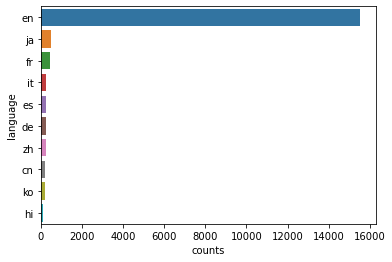

In [337]:
languages = data.groupby('language').size().reset_index(name = 'counts').sort_values('counts', ascending = False).head(10).reset_index(drop = True)
sns.barplot(y = 'language', x = 'counts', data = languages)
plt.show()

In [339]:
data = data[data['language'] == 'en']

In [ ]:
data.drop('language', 1, inplace = True)

In [727]:
data.shape

(15501, 7)

In [728]:
data.drop_duplicates(subset = 'imdb_code', keep = "last", inplace = True)

<ipython-input-728-98429cb03fbf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop_duplicates(subset = 'imdb_code', keep = "last", inplace = True)


In [729]:
data.shape

(15212, 7)

In [730]:
data.describe()

,year,runtime,rating
count,15212.000000,15212.000000,15212.000000
mean,2001.882264,100.644557,5.958756
std,20.177153,18.380970,1.220152
min,1915.000000,70.000000,2.500000
25%,1992.000000,89.000000,5.200000
50%,2011.000000,97.000000,6.100000
75%,2017.000000,108.000000,6.800000
max,2020.000000,364.000000,9.400000


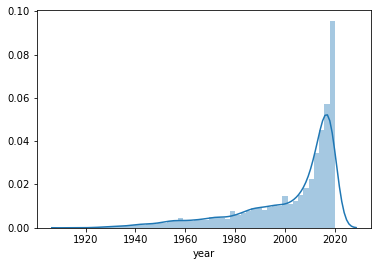

In [731]:
sns.distplot(data['year'])

In [735]:
data = data[data['year'] > 1980]

Apply function to get extra data from IMDb

In [736]:
data.reset_index(inplace = True, drop = True)

In [737]:
x = data.copy()

In [ ]:
start_time = time.time()

x['imdb_data'] = x['imdb_code'].apply(lambda x: get_imdb_data(x))

print("--- %s seconds ---" % (time.time() - start_time))

In [656]:
x.head()

,title,year,runtime,rating,genres,summary,language,imdb_code,imdb_data
0,Memoirs of an Invisible Man,1992,99,6.0,"[Comedy, Romance, Sci-Fi, Thriller]",Nick Halloway is made invisible during an acci...,en,tt0104850,"([Chevy Chase, Daryl Hannah, Sam Neill], [John..."
1,Barbie Princess Adventure,2020,72,7.0,[Animation],Sing-along with Barbie in the all-new musical ...,en,tt12767498,"([Ogie Banks, Eamon Brennan, Nakia Burrise], [..."
2,Feels Good Man,2020,92,7.2,"[Comedy, Documentary]","Artist Matt Furie, creator of the comic charac...",en,tt11394182,"([Robert Barnes, Samantha Bee, Hillary Clinton..."
3,Blue Money,1972,93,4.3,[Drama],Handsome and successful Jim appears to have it...,en,tt0211957,"([Alain Patrick, Barbara Mills, Inga Maria], [..."
4,Beautiful & Twisted,2015,86,5.6,"[Crime, Drama, Thriller]",Following the murder of hotel heir Ben Novack ...,en,tt3881768,"([Rob Lowe, Paz Vega, Candice Bergen], [Christ..."


In [657]:
x.to_csv('sample_movies_w_imdb_data.csv', index = False)

### Enhancement ideas so far
1. Scrape IMDB webpage
2. Use IMDb() function from imdb py package
3. Use TMDb API to parse an IMDB id, find TMDb id and via the TMDb id get budget and revenue data

#### Will use option # 3 as scraping is time consuming, IMDb() is very slow, TMDB API allows ~300k requests a day
 
 

In [703]:
pd.read_csv('sample_movies_w_imdb_data.csv')['imdb_data'][0]

"(['Chevy Chase', 'Daryl Hannah', 'Sam Neill'], ['John Carpenter'], ['H.F. Saint', 'Robert Collector'], {'Budget': '$40,000,000 (estimated)'})"

In [844]:
def enhance_via_tmdb_api(imdb_id):
    
    api = '7031a9194bc4599cfda684b748a523a9'

    link = 'https://api.themoviedb.org/3/find/' + imdb_id + '?api_key=' + api + '&language=en-US&external_source=imdb_id'
    read_json_imdb = loads(ur.urlopen(link).read())
    
    if read_json_imdb['movie_results'] != []:
        tmdb_id = read_json_imdb['movie_results'][0]['id'] # get tmdb id of the movie
    else:
        return [], [], [], []        

    link = 'https://api.themoviedb.org/3/movie/' + str(tmdb_id) + '?api_key=' + api + '&language=en-US'
    
    try:
        
        # get financials
        financials = loads(ur.urlopen(link).read())

        budget = financials['budget']
        revenue = financials['revenue']

        financials = {'budget' : budget, 'revenue' : revenue}

        # get cast / crew data
        link = 'https://api.themoviedb.org/3/movie/' + str(tmdb_id) + '/credits?api_key=' + api
        cast_crew = loads(ur.urlopen(link).read())

        # actors
        actors = []
        limit = 3
        for i, actor in enumerate(cast_crew['cast']):
            actors.append(actor['name'])
            if i == limit - 1:
                break

        # writers and directors
        if cast_crew['crew'] != []:
            crew = pd.json_normalize(cast_crew['crew'])
            crew = crew[(crew['department'].isin(['Writing', 'Directing'])) & (crew['job'].isin(['Screenplay', 'Director']))]
            writers = list(crew[crew['department'] == 'Writing']['name'][:2])
            directors = list(crew[crew['department'] == 'Directing']['name'][:2])
        else:
            writers, directors = [], []
        
    except ur.HTTPError as err:
        if err.code == 404:
            return [], [], [], []
    
    return actors, directors, writers, financials

In [1234]:
x = data.copy()[10000:]

In [1236]:
start_time = time.time()
x['imdb_data'] = x['imdb_code'].apply(lambda x: enhance_via_tmdb_api(x))
print("--- %s seconds ---" % (time.time() - start_time))

--- 2418.4689898490906 seconds ---


In [1237]:
x.to_csv('movies_w_imdb_data_6.csv', index = False)

In [1238]:
x = pd.read_csv('movies_w_imdb_data_all.csv').append(x).reset_index(drop = True)
x.shape

(12904, 8)

In [1241]:
x.to_csv('movies_w_imdb_data_all.csv', index = False)

### Start here

### Analyze all actors, directors, writers (not just lead ones) --> for this use pd.explode() on the list values

In [1621]:
x = pd.read_csv('movies_w_imdb_data_all.csv')

x['imdb_data'] = x['imdb_data'].apply(lambda x: ast.literal_eval(x))
x['lead_actors'] = x['imdb_data'].apply(lambda x: x[0])
x['directors'] = x['imdb_data'].apply(lambda x: x[1])
x['writers'] = x['imdb_data'].apply(lambda x: x[2])
x['financials'] = x['imdb_data'].apply(lambda x: x[3])

x.drop('imdb_data', 1, inplace = True)

x['budget'] = x['financials'].apply(lambda x: x['budget'] if (isinstance(x, dict) and 'budget' in x.keys()) else float('nan'))
x['revenue'] = x['financials'].apply(lambda x: x['revenue'] if (isinstance(x, dict) and 'revenue' in x.keys()) else float('nan'))

x.drop('financials', 1, inplace = True)

x['roi'] = x['revenue'] / x['budget']
x['roi'] = x['roi'].replace(inf, nan)

x.head(1)

,title,year,runtime,rating,genres,summary,imdb_code,lead_actors,directors,writers,budget,revenue,roi
0,Memoirs of an Invisible Man,1992,99,6.0,"['Comedy', 'Romance', 'Sci-Fi', 'Thriller']",Nick Halloway is made invisible during an acci...,tt0104850,"[Chevy Chase, Daryl Hannah, Sam Neill]",[John Carpenter],"[William Goldman, Robert Collector]",40000000.0,14358033.0,0.358951


#### Actors

In [1365]:
actors = x.explode('lead_actors')[['title', 'lead_actors', 'rating', 'budget', 'revenue', 'roi']].reset_index(drop = True)
actors.head(3)

,title,lead_actors,rating,budget,revenue,roi
0,Memoirs of an Invisible Man,Chevy Chase,6.0,40000000.0,14358033.0,0.358951
1,Memoirs of an Invisible Man,Daryl Hannah,6.0,40000000.0,14358033.0,0.358951
2,Memoirs of an Invisible Man,Sam Neill,6.0,40000000.0,14358033.0,0.358951


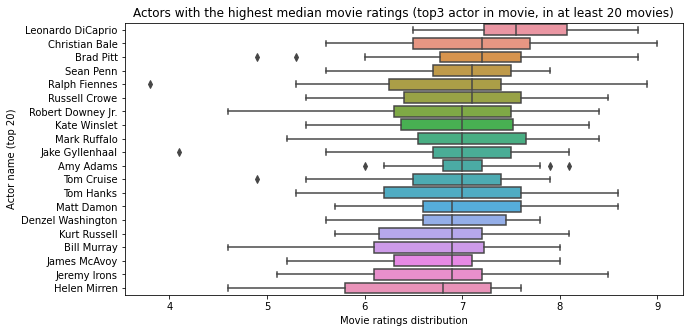

In [1400]:
top_act_index = actors.groupby(by=['lead_actors'])['rating'].agg(['count', 'median']).reset_index()
top_act_index = top_act_index[top_act_index['count'] > 20].sort_values('median', ascending = False).reset_index(drop = True)
top_act_index = top_act_index[:20]

top_act_data = actors[actors['lead_actors'].isin(top_act_index['lead_actors'])]

fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(x = 'rating', y = 'lead_actors', data = top_act_data, order = top_act_index['lead_actors'])
plt.xlabel("Movie ratings distribution")
plt.ylabel("Actor name (top 20)")
plt.title("Actors with the highest median movie ratings (top3 actor in movie, in at least 20 movies)")
plt.show()

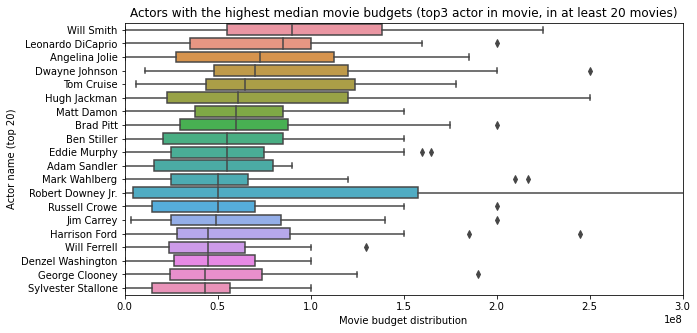

In [1401]:
top_act_index = actors.groupby(by=['lead_actors'])['budget'].agg(['count', 'median']).reset_index()
top_act_index = top_act_index[top_act_index['count'] > 20].sort_values('median', ascending = False).reset_index(drop = True)
top_act_index = top_act_index[:20]

top_act_data = actors[actors['lead_actors'].isin(top_act_index['lead_actors'])]

fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(x = 'budget', y = 'lead_actors', data = top_act_data, order = top_act_index['lead_actors'])
plt.xlabel("Movie budget distribution")
plt.ylabel("Actor name (top 20)")
plt.title("Actors with the highest median movie budgets (top3 actor in movie, in at least 20 movies)")
plt.xlim(0, 3e8)
plt.show()

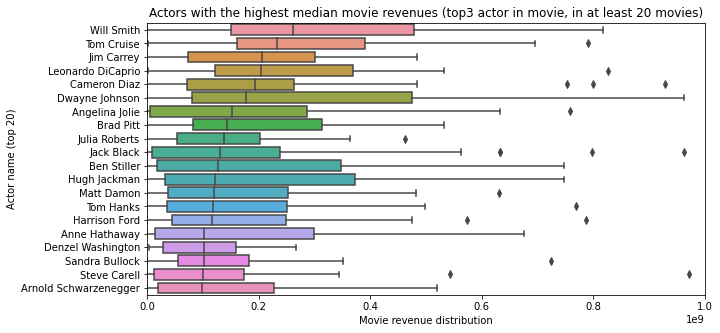

In [1402]:
top_act_index = actors.groupby(by=['lead_actors'])['revenue'].agg(['count', 'median']).reset_index()
top_act_index = top_act_index[top_act_index['count'] > 20].sort_values('median', ascending = False).reset_index(drop = True)
top_act_index = top_act_index[:20]

top_act_data = actors[actors['lead_actors'].isin(top_act_index['lead_actors'])]

fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(x = 'revenue', y = 'lead_actors', data = top_act_data, order = top_act_index['lead_actors'])
plt.xlabel("Movie revenue distribution")
plt.ylabel("Actor name (top 20)")
plt.title("Actors with the highest median movie revenues (top3 actor in movie, in at least 20 movies)")
plt.xlim(0, 1e9)
plt.show()

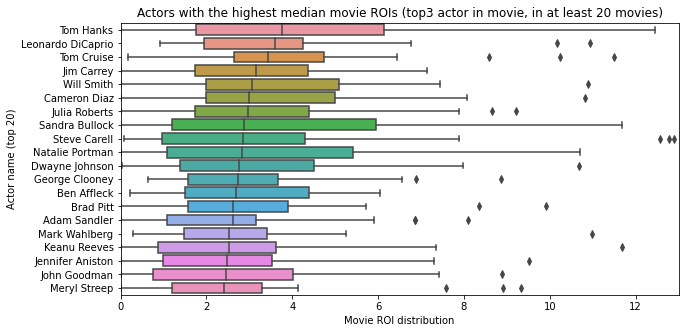

In [1403]:
top_act_index = actors.groupby(by=['lead_actors'])['roi'].agg(['count', 'median']).reset_index()
top_act_index = top_act_index[top_act_index['count'] > 20].sort_values('median', ascending = False).reset_index(drop = True)
top_act_index = top_act_index[:20]

top_act_data = actors[actors['lead_actors'].isin(top_act_index['lead_actors'])]

fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(x = 'roi', y = 'lead_actors', data = top_act_data, order = top_act_index['lead_actors'])
plt.xlabel("Movie ROI distribution")
plt.ylabel("Actor name (top 20)")
plt.title("Actors with the highest median movie ROIs (top3 actor in movie, in at least 20 movies)")
plt.xlim(0, 13)
plt.show()

#### Directors

In [1431]:
directors = x.explode('directors')[['title', 'directors', 'rating', 'budget', 'revenue', 'roi']].reset_index(drop = True)
directors['roi'] = directors['roi'].replace(inf, nan)
directors.head(3)

,title,directors,rating,budget,revenue,roi
0,Memoirs of an Invisible Man,John Carpenter,6.0,40000000.0,14358033.0,0.358951
1,Barbie Princess Adventure,Conrad Helten,7.0,0.0,0.0,NaN
2,Feels Good Man,Arthur Jones,7.2,0.0,0.0,NaN


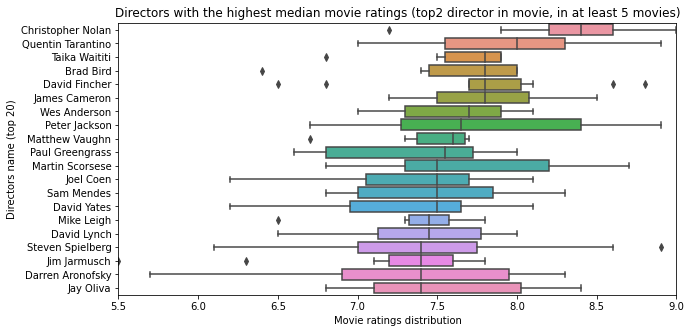

In [1434]:
top_dir_index = directors.groupby(by=['directors'])['rating'].agg(['count', 'median']).reset_index()
top_dir_index = top_dir_index[top_dir_index['count'] > 5].sort_values('median', ascending = False).reset_index(drop = True)
top_dir_index = top_dir_index[:20]

top_dir_data = directors[directors['directors'].isin(top_dir_index['directors'])]

fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(x = 'rating', y = 'directors', data = top_dir_data, order = top_dir_index['directors'])
plt.xlabel("Movie ratings distribution")
plt.ylabel("Directors name (top 20)")
plt.title("Directors with the highest median movie ratings (top2 director in movie, in at least 5 movies)")
plt.xlim(5.5, 9)
plt.show()

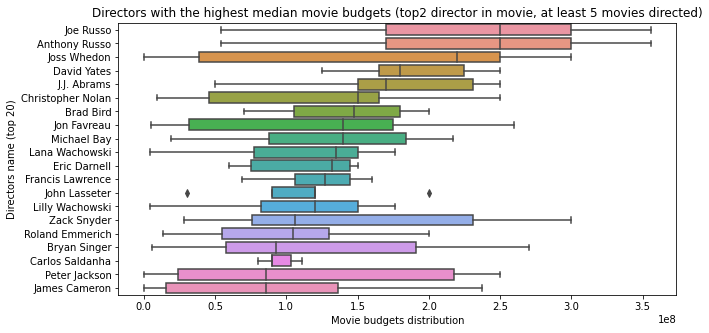

In [1441]:
top_dir_bud_index = directors.groupby(by=['directors'])['budget'].agg(['count', 'median']).reset_index()
top_dir_bud_index = top_dir_bud_index[top_dir_bud_index['count'] >= 5].sort_values('median', ascending = False).reset_index(drop = True)
top_dir_bud_index = top_dir_bud_index[:20]

top_dir_bud_data = directors[directors['directors'].isin(top_dir_bud_index['directors'])]

fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(x = 'budget', y = 'directors', data = top_dir_bud_data, order = top_dir_bud_index['directors'])
plt.xlabel("Movie budgets distribution")
plt.ylabel("Directors name (top 20)")
plt.title("Directors with the highest median movie budgets (top2 director in movie, at least 5 movies directed)")
plt.show()

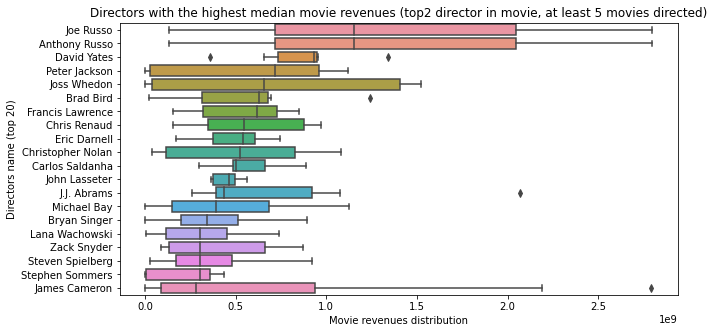

In [1442]:
top_dir_bud_index = directors.groupby(by=['directors'])['revenue'].agg(['count', 'median']).reset_index()
top_dir_bud_index = top_dir_bud_index[top_dir_bud_index['count'] >= 5].sort_values('median', ascending = False).reset_index(drop = True)
top_dir_bud_index = top_dir_bud_index[:20]

top_dir_bud_data = directors[directors['directors'].isin(top_dir_bud_index['directors'])]

fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(x = 'revenue', y = 'directors', data = top_dir_bud_data, order = top_dir_bud_index['directors'])
plt.xlabel("Movie revenues distribution")
plt.ylabel("Directors name (top 20)")
plt.title("Directors with the highest median movie revenues (top2 director in movie, at least 5 movies directed)")
plt.show()

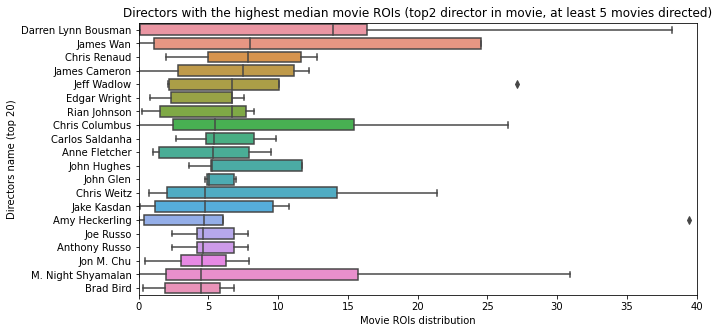

In [1443]:
top_dir_bud_index = directors.groupby(by=['directors'])['roi'].agg(['count', 'median']).reset_index()
top_dir_bud_index = top_dir_bud_index[top_dir_bud_index['count'] >= 5].sort_values('median', ascending = False).reset_index(drop = True)
top_dir_bud_index = top_dir_bud_index[:20]

top_dir_bud_data = directors[directors['directors'].isin(top_dir_bud_index['directors'])]

fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(x = 'roi', y = 'directors', data = top_dir_bud_data, order = top_dir_bud_index['directors'])
plt.xlabel("Movie ROIs distribution")
plt.ylabel("Directors name (top 20)")
plt.title("Directors with the highest median movie ROIs (top2 director in movie, at least 5 movies directed)")
plt.xlim(0, 40)
plt.show()

#### Writers

In [1440]:
writers = x.explode('writers')[['title', 'writers', 'rating', 'budget', 'revenue', 'roi']].reset_index(drop = True)
writers['roi'] = writers['roi'].replace(inf, nan)
writers.head(3)

,title,writers,rating,budget,revenue,roi
0,Memoirs of an Invisible Man,William Goldman,6.0,40000000.0,14358033.0,0.358951
1,Memoirs of an Invisible Man,Robert Collector,6.0,40000000.0,14358033.0,0.358951
2,Barbie Princess Adventure,NaN,7.0,0.0,0.0,NaN


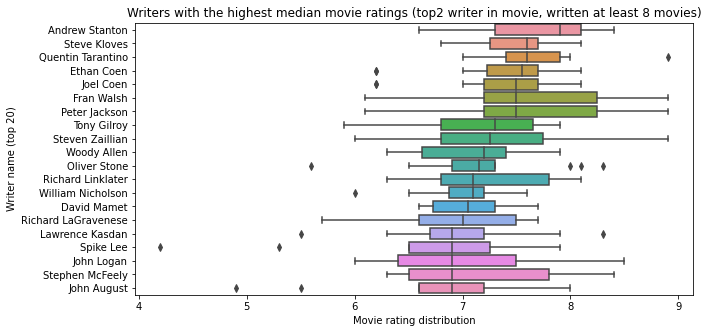

In [1451]:
top_wri_index = writers.groupby(by=['writers'])['rating'].agg(['count', 'median']).reset_index()
top_wri_index = top_wri_index[top_wri_index['count'] > 8].sort_values('median', ascending = False).reset_index(drop = True)
top_wri_index = top_wri_index[:20]

top_wri_data = writers[writers['writers'].isin(top_wri_index['writers'])]

fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(x = 'rating', y = 'writers', data = top_wri_data, order = top_wri_index['writers'])
plt.xlabel("Movie rating distribution")
plt.ylabel("Writer name (top 20)")
plt.title("Writers with the highest median movie ratings (top2 writer in movie, written at least 8 movies)")
#plt.xlim(0, 13)
plt.show()

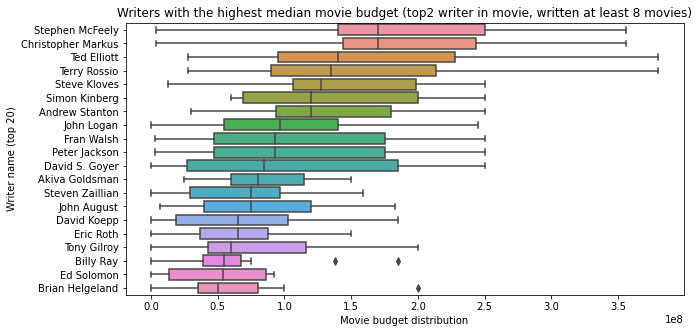

In [1452]:
top_wri_index = writers.groupby(by=['writers'])['budget'].agg(['count', 'median']).reset_index()
top_wri_index = top_wri_index[top_wri_index['count'] > 8].sort_values('median', ascending = False).reset_index(drop = True)
top_wri_index = top_wri_index[:20]

top_wri_data = writers[writers['writers'].isin(top_wri_index['writers'])]

fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(x = 'budget', y = 'writers', data = top_wri_data, order = top_wri_index['writers'])
plt.xlabel("Movie budget distribution")
plt.ylabel("Writer name (top 20)")
plt.title("Writers with the highest median movie budget (top2 writer in movie, written at least 8 movies)")
#plt.xlim(0, 13)
plt.show()

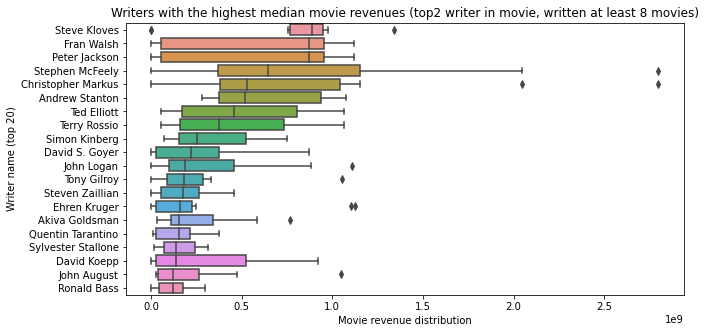

In [1453]:
top_wri_index = writers.groupby(by=['writers'])['revenue'].agg(['count', 'median']).reset_index()
top_wri_index = top_wri_index[top_wri_index['count'] > 8].sort_values('median', ascending = False).reset_index(drop = True)
top_wri_index = top_wri_index[:20]

top_wri_data = writers[writers['writers'].isin(top_wri_index['writers'])]

fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(x = 'revenue', y = 'writers', data = top_wri_data, order = top_wri_index['writers'])
plt.xlabel("Movie revenue distribution")
plt.ylabel("Writer name (top 20)")
plt.title("Writers with the highest median movie revenues (top2 writer in movie, written at least 8 movies)")
#plt.xlim(0, 13)
plt.show()

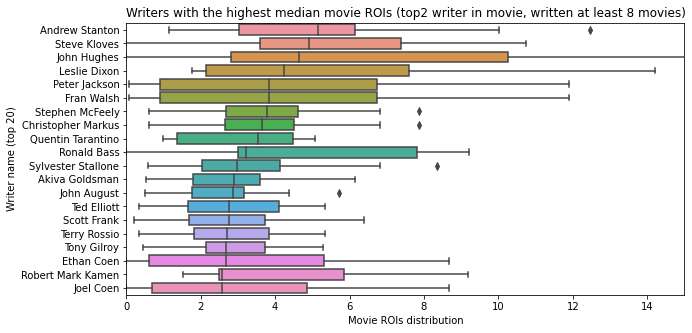

In [1455]:
top_wri_index = writers.groupby(by=['writers'])['roi'].agg(['count', 'median']).reset_index()
top_wri_index = top_wri_index[top_wri_index['count'] > 8].sort_values('median', ascending = False).reset_index(drop = True)
top_wri_index = top_wri_index[:20]

top_wri_data = writers[writers['writers'].isin(top_wri_index['writers'])]

fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(x = 'roi', y = 'writers', data = top_wri_data, order = top_wri_index['writers'])
plt.xlabel("Movie ROIs distribution")
plt.ylabel("Writer name (top 20)")
plt.title("Writers with the highest median movie ROIs (top2 writer in movie, written at least 8 movies)")
plt.xlim(0, 15)
plt.show()

### Financials

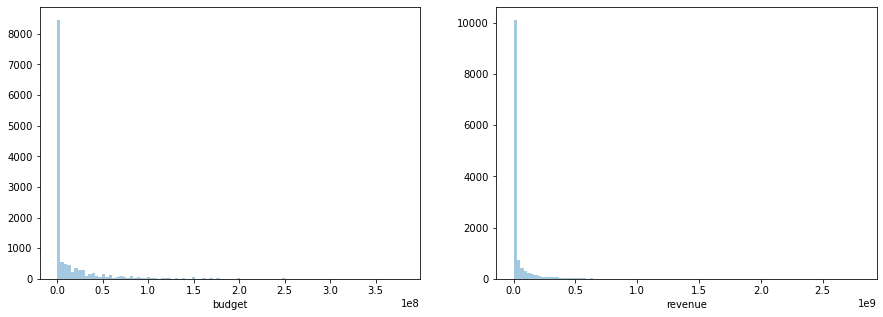

In [1460]:
fig, ax = plt.subplots(ncols = 2, figsize = (15, 5))

sns.distplot(x['budget'], bins = 100, kde = False, ax = ax[0])
sns.distplot(x['revenue'], bins = 100, kde = False, ax = ax[1])

plt.show()

In [1461]:
print('budget missing:', round(x['budget'].isnull().sum() / len(x['budget']) * 100, 3), '%')
print('revenue missing:', round(x['revenue'].isnull().sum() / len(x['revenue']) * 100, 3), '%')
print('budget = 0:', round((x['budget'] == 0).sum() / len(x['budget']) * 100, 3), '%')
print('revenue = 0:', round((x['revenue'] == 0).sum() / len(x['revenue']) * 100, 3), '%')

budget missing: 0.325 %
revenue missing: 0.325 %
budget = 0: 57.92 %
revenue = 0: 59.795 %


In [1487]:
x_finances = x[x['budget'] > 1000000] # at least $1m budget

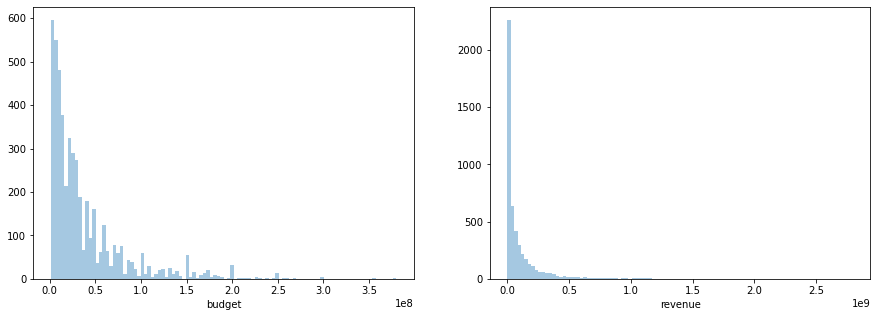

In [1488]:
fig, ax = plt.subplots(ncols = 2, figsize = (15, 5))

sns.distplot(x_finances['budget'], bins = 100, kde = False, ax = ax[0])
sns.distplot(x_finances['revenue'], bins = 100, kde = False, ax = ax[1])

plt.show()

Financials and rating relationship

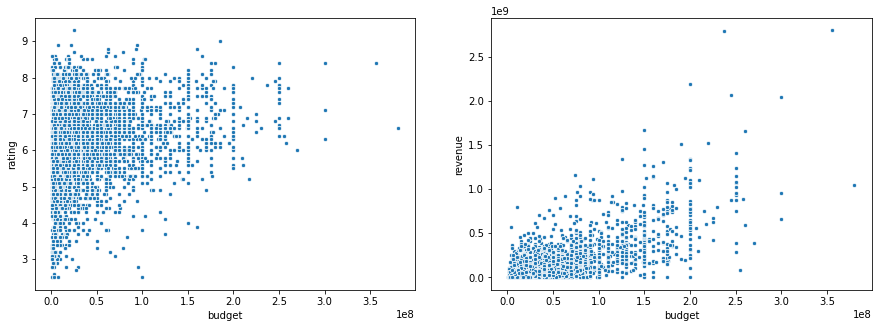

In [1515]:
fig, ax = plt.subplots(ncols = 2, figsize = (15, 5))

sns.scatterplot(x = 'budget', y = 'rating', marker = '.', s = 70, data = x_finances, ax = ax[0])
sns.scatterplot(x = 'budget', y = 'revenue', marker = '.', s = 70, data = x_finances, ax = ax[1])

plt.show()

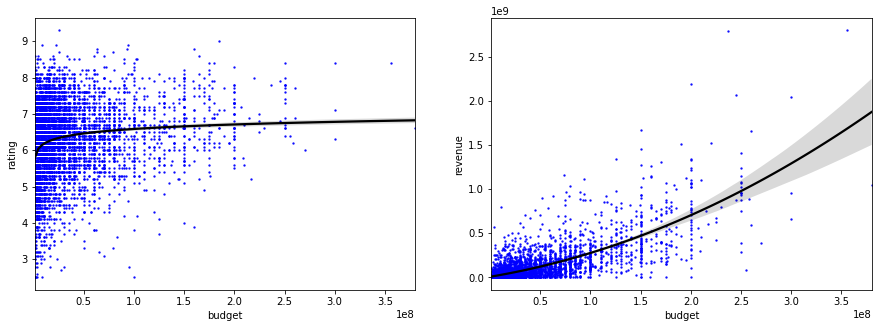

In [1542]:
fig, ax = plt.subplots(ncols = 2, figsize = (15, 5))

sns.regplot(x = 'budget', y = 'rating', logx = True, data = x_finances, ax = ax[0], color = 'black', scatter_kws={'s':2, 'color':'blue'})
sns.regplot(x = 'budget', y = 'revenue', order = 2, data = x_finances, ax = ax[1], color = 'black', scatter_kws={'s':2, 'color':'blue'})

plt.show()

Movies with largest budgets, largest revenues, ROIs (all movies have a budget of at least $1m)

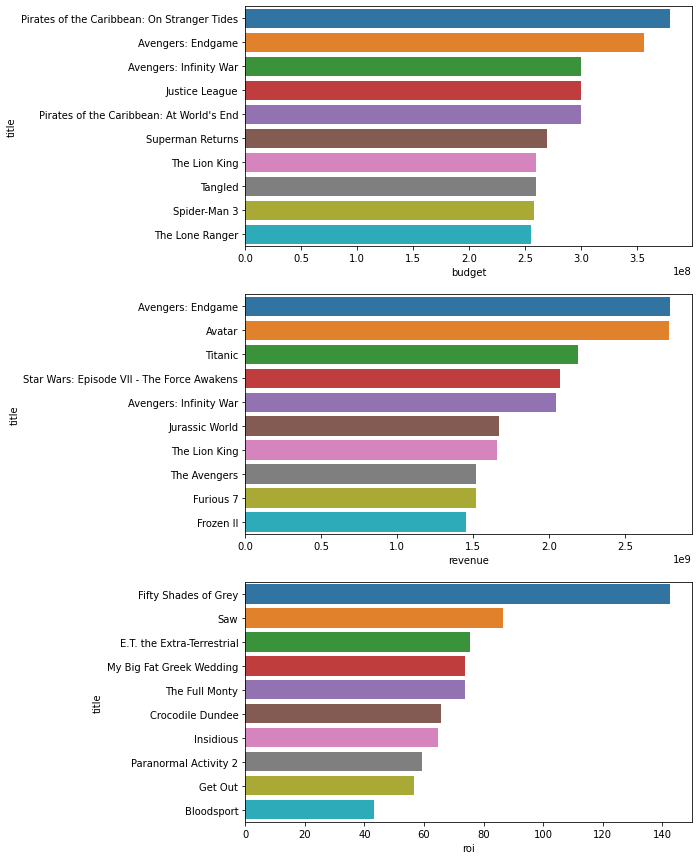

In [1491]:
top_budgets = x_finances.sort_values('budget', ascending = False)[['title', 'budget']][:10].reset_index(drop = True)
top_revenue = x_finances.sort_values('revenue', ascending = False)[['title', 'revenue']][:10].reset_index(drop = True)
top_roi = x_finances.sort_values('roi', ascending = False)[['title', 'roi']][:10].reset_index(drop = True)
top_roi = top_roi[top_roi['roi'] < 1000000] # one error above 1mil ROI

fig, ax = plt.subplots(nrows = 3, figsize = (8, 15))

sns.barplot(x = 'budget', y = 'title', data = top_budgets, ax = ax[0])
sns.barplot(x = 'revenue', y = 'title', data = top_revenue, ax = ax[1])
sns.barplot(x = 'roi', y = 'title', data = top_roi, ax = ax[2])

plt.show()

### Trend change by years

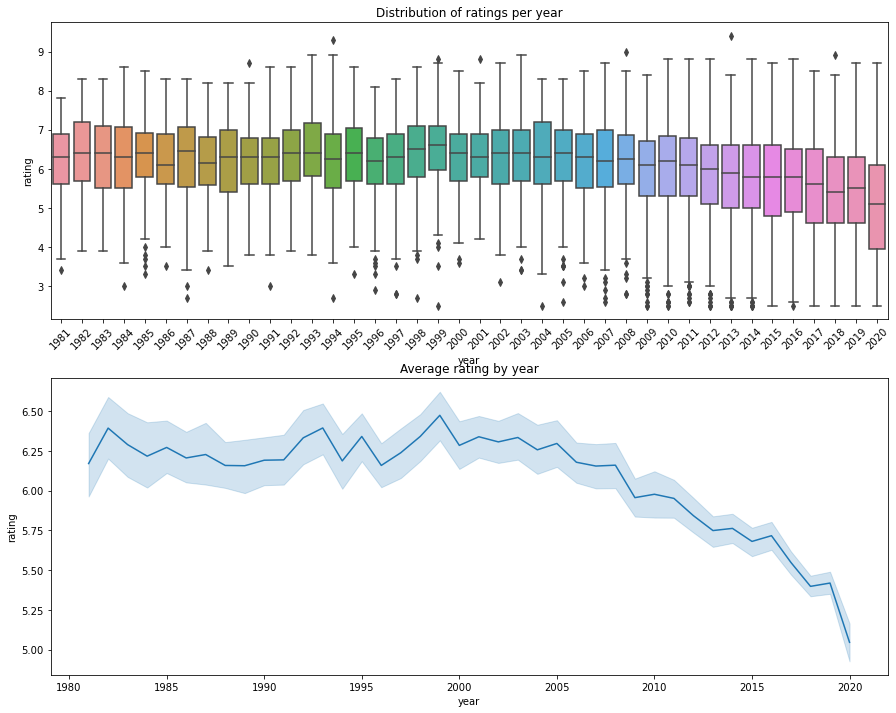

In [1583]:
fig, ax = plt.subplots(nrows = 2, figsize = (15, 12))

sns.boxplot('year', 'rating', data = x, ax = ax[0])
ax[0].set_xticklabels(labels = ax[0].get_xticklabels(), rotation=45)
ax[0].set_title('Distribution of ratings per year')

sns.lineplot('year', 'rating', data = x, ax = ax[1], estimator = 'mean')
ax[1].set_title('Average rating by year')

plt.show()

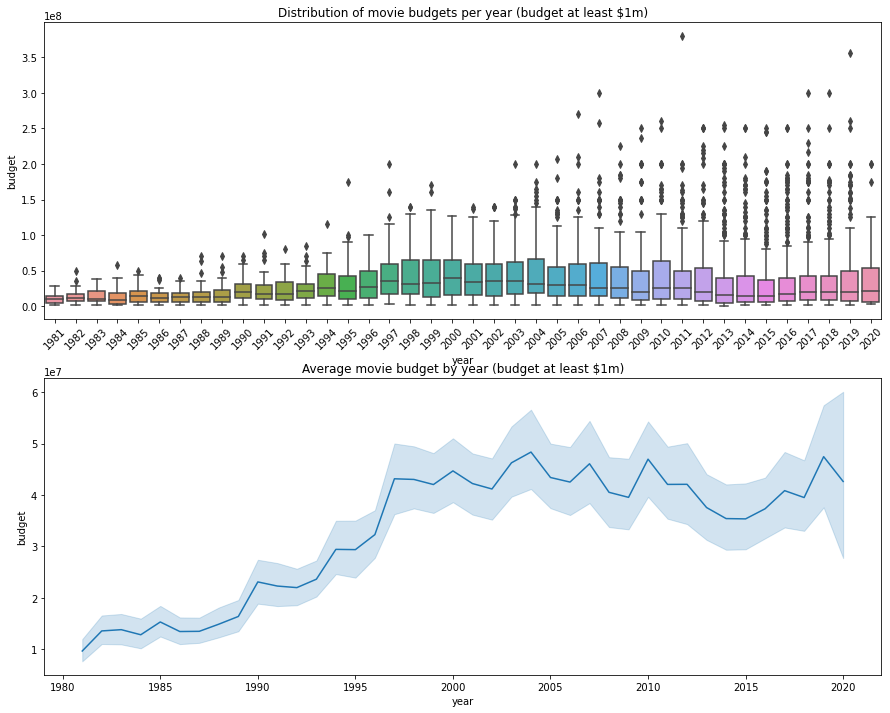

In [1591]:
fig, ax = plt.subplots(nrows = 2, figsize = (15, 12))

sns.boxplot('year', 'budget', data = x_finances, ax = ax[0])
ax[0].set_xticklabels(labels = ax[0].get_xticklabels(), rotation=45)
ax[0].set_title('Distribution of movie budgets per year (budget at least $1m)')

sns.lineplot('year', 'budget', data = x_finances, ax = ax[1], estimator = 'mean')
ax[1].set_title('Average movie budget by year (budget at least $1m)')

plt.show()

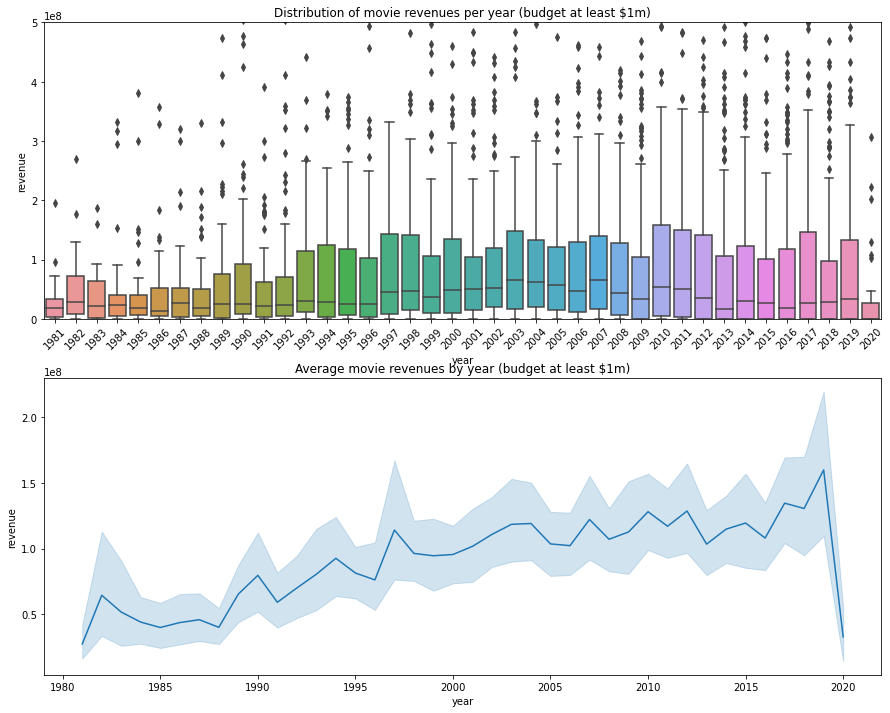

In [1599]:
fig, ax = plt.subplots(nrows = 2, figsize = (15, 12))

sns.boxplot('year', 'revenue', data = x_finances, ax = ax[0])
ax[0].set_xticklabels(labels = ax[0].get_xticklabels(), rotation=45)
ax[0].set_title('Distribution of movie revenues per year (budget at least $1m)')
ax[0].set_ylim(0, 0.5e9)

sns.lineplot('year', 'revenue', data = x_finances, ax = ax[1], estimator = 'mean')
ax[1].set_title('Average movie revenues by year (budget at least $1m)')

plt.show()

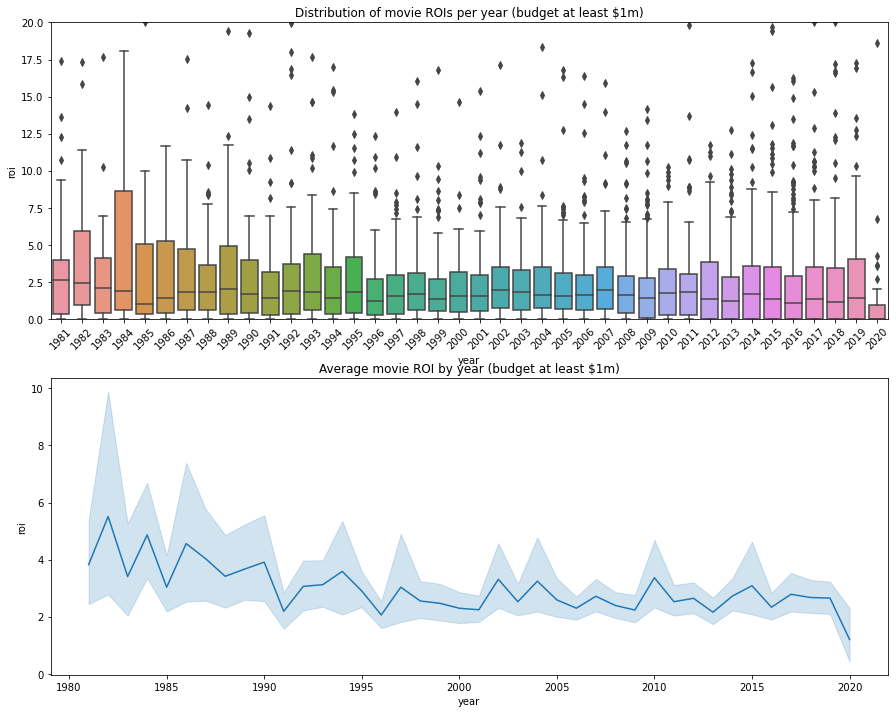

In [1595]:
fig, ax = plt.subplots(nrows = 2, figsize = (15, 12))

sns.boxplot('year', 'roi', data = x_finances, ax = ax[0])
ax[0].set_xticklabels(labels = ax[0].get_xticklabels(), rotation=45)
ax[0].set_title('Distribution of movie ROIs per year (budget at least $1m)')
ax[0].set_ylim(0, 20)

sns.lineplot('year', 'roi', data = x_finances, ax = ax[1], estimator = 'mean')
ax[1].set_title('Average movie ROI by year (budget at least $1m)')

plt.show()

### Genre analysis

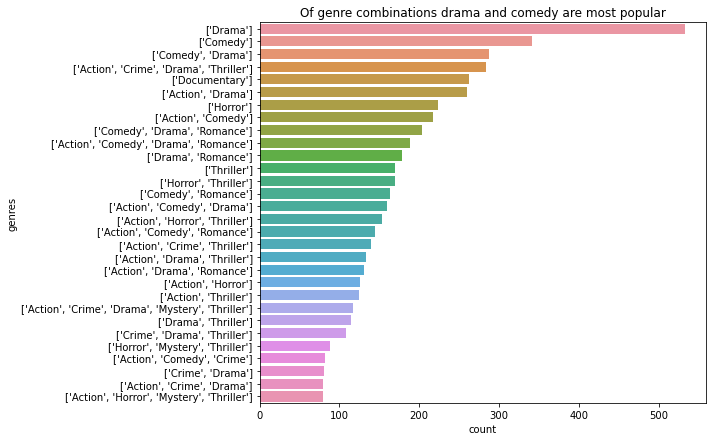

In [1784]:
genres_grouped = pd.DataFrame(x[x['genres'].notnull()].groupby('genres').count()['title'].sort_values(ascending = False)[:30].reset_index().rename(columns = {'title' : 'count'}))
plt.figure(figsize=(8,7))
sns.barplot(y = 'genres', x = 'count', data = genres_grouped)
plt.title('Of genre combinations drama and comedy are most popular')
plt.show()

In [1785]:
genres = x[x['genres'].notnull()]
genres['genres'] = genres['genres'].apply(lambda x: ast.literal_eval(x))
genres = genres.explode('genres')[['title', 'year', 'genres', 'rating', 'budget', 'revenue', 'roi']].reset_index(drop = True)
genres['roi'] = genres['roi'].replace(inf, nan)
genres.head()

<ipython-input-1785-d2299d83f714>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genres['genres'] = genres['genres'].apply(lambda x: ast.literal_eval(x))


,title,year,genres,rating,budget,revenue,roi
0,Memoirs of an Invisible Man,1992,Comedy,6.0,40000000.0,14358033.0,0.358951
1,Memoirs of an Invisible Man,1992,Romance,6.0,40000000.0,14358033.0,0.358951
2,Memoirs of an Invisible Man,1992,Sci-Fi,6.0,40000000.0,14358033.0,0.358951
3,Memoirs of an Invisible Man,1992,Thriller,6.0,40000000.0,14358033.0,0.358951
4,Barbie Princess Adventure,2020,Animation,7.0,0.0,0.0,NaN


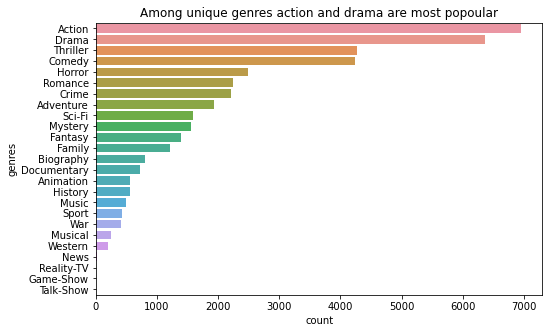

In [1787]:
genres_count = genres.groupby('genres').count().reset_index()[['genres', 'title']].rename(columns = {'title' : 'count'}).sort_values('count', ascending = False)
plt.figure(figsize=(8,5))
sns.barplot(y = 'genres', x = 'count', data = genres_count)
plt.title('Among unique genres action and drama are most popoular')
plt.show()

In [1789]:
genre_freq = pd.DataFrame(genres.groupby('genres')['title'].count().sort_values(ascending = False))
total_sum = sum(genre_freq['title'])
genre_freq['rel'] = genre_freq['title'] * 100 / total_sum
genre_freq.reset_index()[:21]

,genres,title,rel
0,Action,6957,17.009364
1,Drama,6373,15.581526
2,Thriller,4279,10.461847
3,Comedy,4244,10.376274
4,Horror,2487,6.080536
5,Romance,2248,5.496198
6,Crime,2207,5.395956
7,Adventure,1936,4.733381
8,Sci-Fi,1585,3.875211
9,Mystery,1563,3.821422


In [1790]:
genres = genres[genres['genres'].isin(genre_freq[:21].reset_index()['genres'])]

In [1791]:
by_year = genres.groupby(['year', 'genres']).count()['title'].reset_index().rename(columns = {'title' : 'count'})
by_year['change'] = by_year.groupby('genres')['count'].apply(lambda x: x.div(x.iloc[0]))
by_year.head()

,year,genres,count,change
0,1981,Action,56,1.0
1,1981,Adventure,20,1.0
2,1981,Animation,3,1.0
3,1981,Biography,2,1.0
4,1981,Comedy,26,1.0


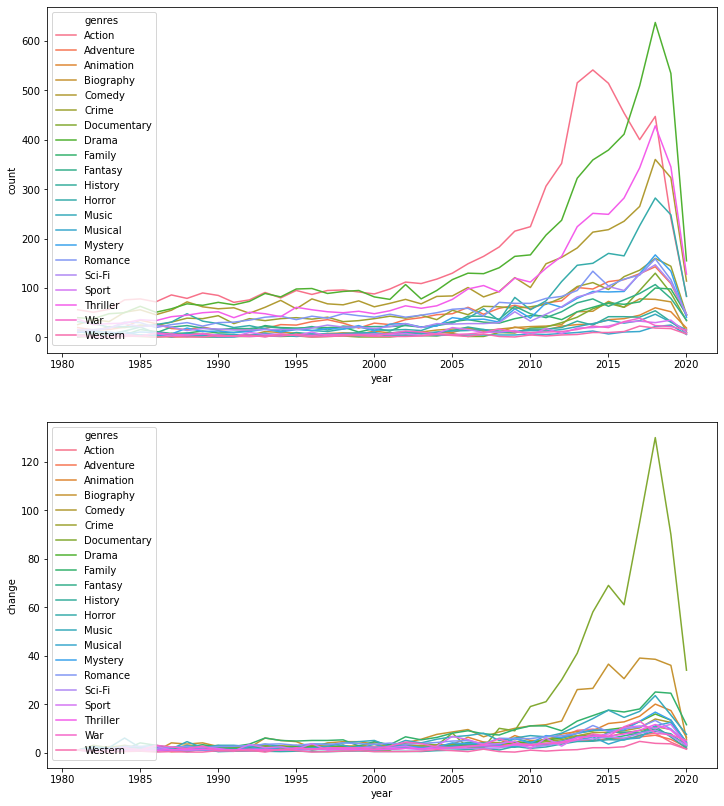

In [1792]:
fig, ax = plt.subplots(nrows = 2, figsize = (12, 14))

sns.lineplot(x = 'year', y = 'count', hue = 'genres', data = by_year, ax = ax[0])
sns.lineplot(x = 'year', y = 'change', hue = 'genres', data = by_year, ax = ax[1])

plt.show()

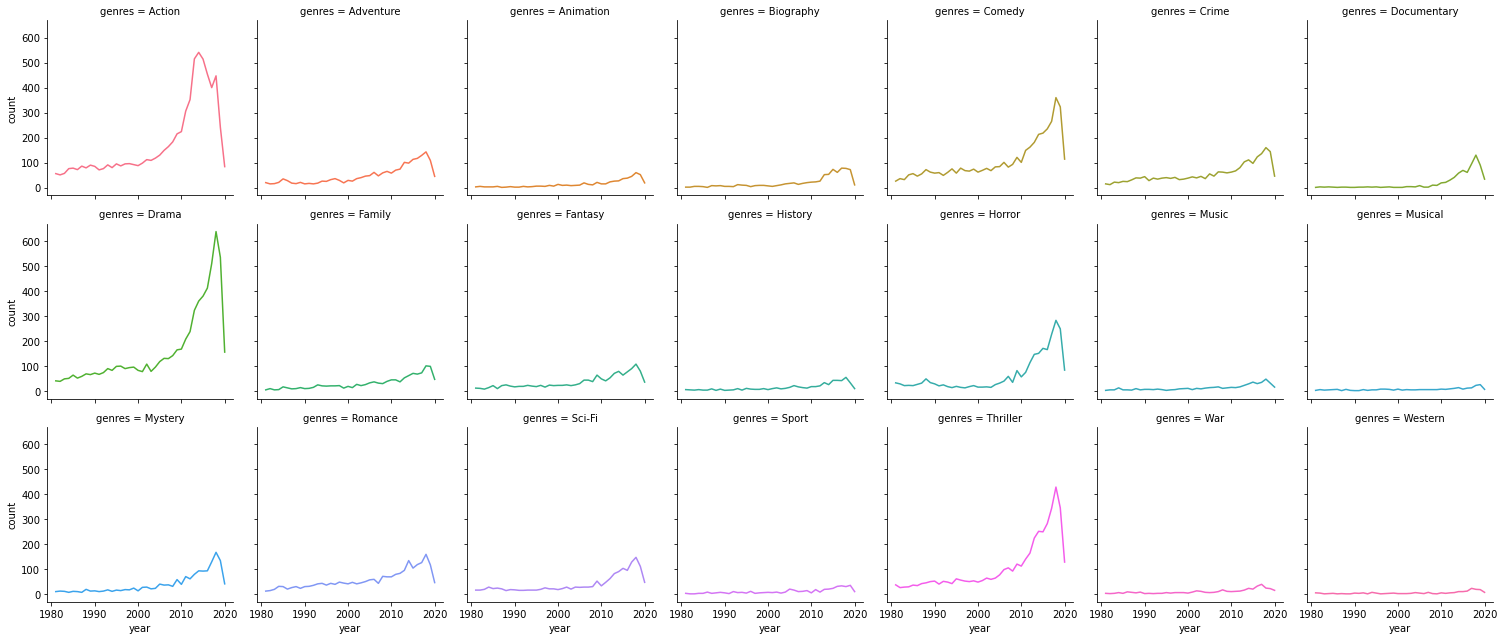

In [1795]:
g = sns.FacetGrid(by_year, col="genres", hue="genres", col_wrap=7, sharex = True)
g.map(sns.lineplot, "year","count")
plt.show()

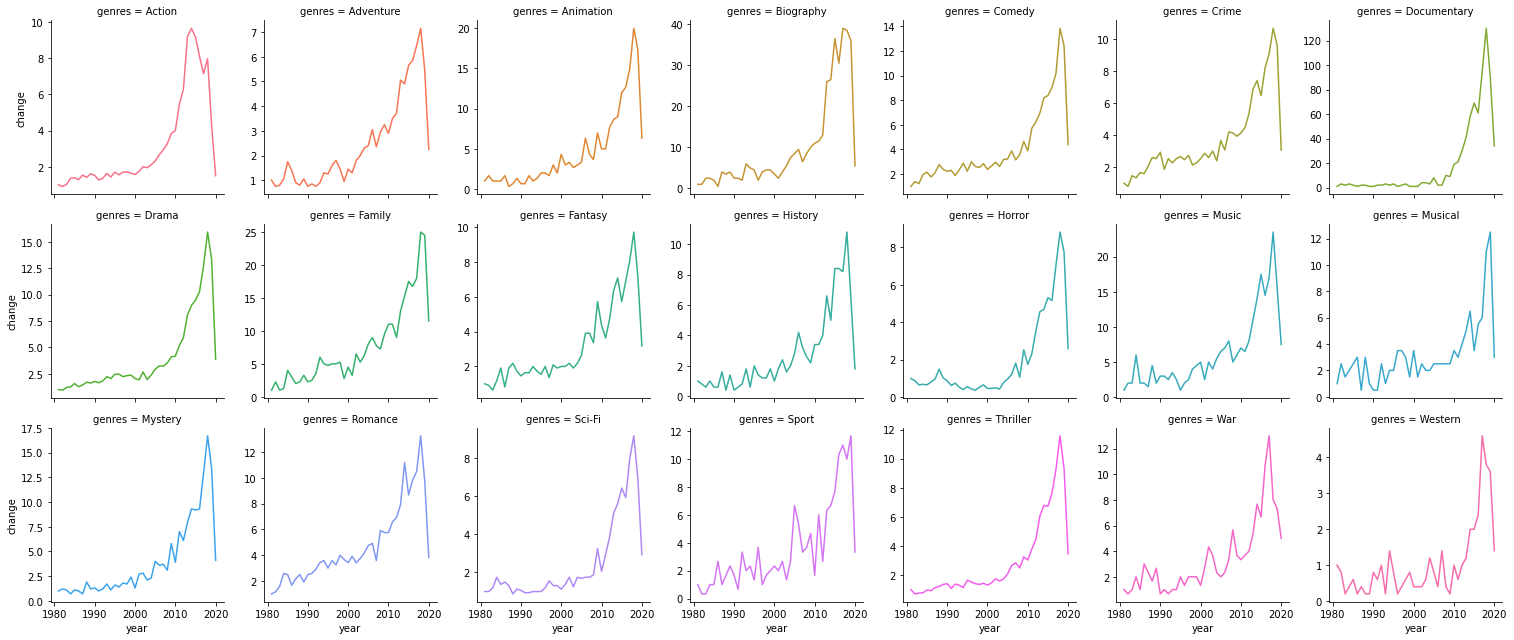

In [1796]:
g = sns.FacetGrid(by_year, col="genres", hue="genres", col_wrap=7, sharex = True, sharey = False)
g.map(sns.lineplot, "year","change")
plt.show()

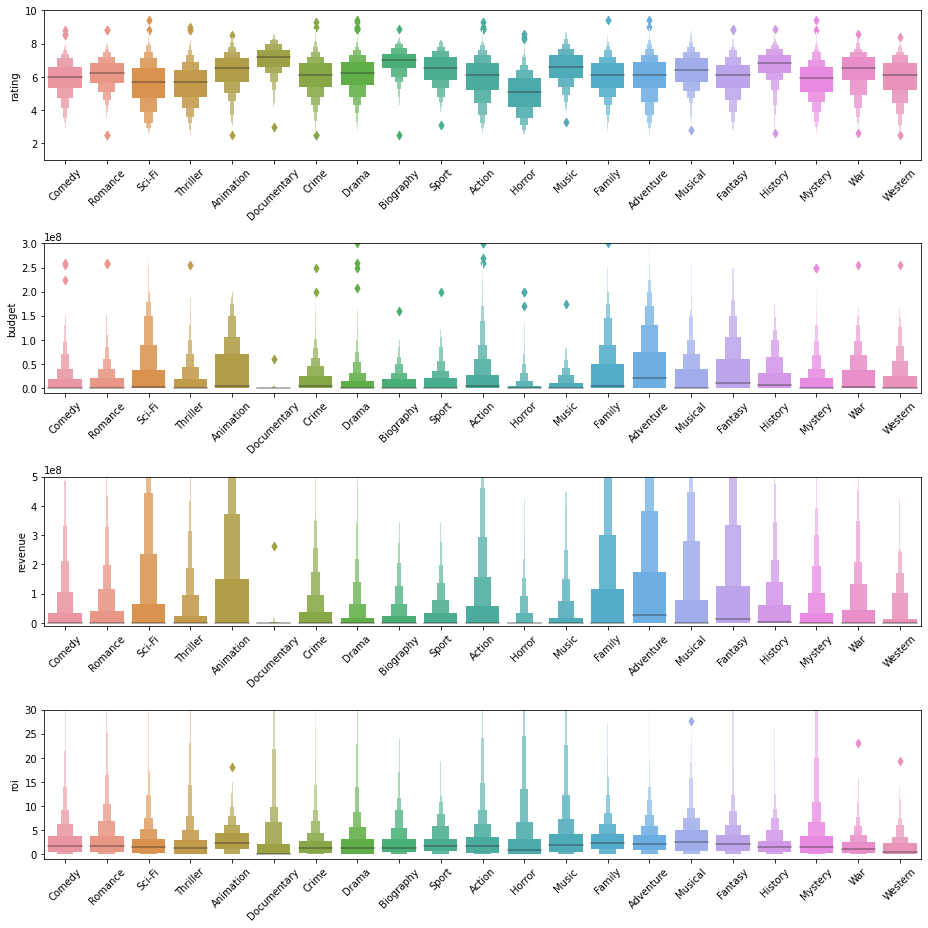

In [1810]:
fig, ax = plt.subplots(nrows = 4, figsize = (13, 13))

sns.boxenplot(x = 'genres', y = 'rating', data = genres, ax = ax[0], dodge = False).set(xlabel=None)
sns.boxenplot(x = 'genres', y = 'budget', data = genres, ax = ax[1], dodge = False).set(xlabel=None)
sns.boxenplot(x = 'genres', y = 'revenue', data = genres, ax = ax[2], dodge = False).set(xlabel=None)
sns.boxenplot(x = 'genres', y = 'roi', data = genres, ax = ax[3], dodge = False).set(xlabel=None)

ax[0].set_ylim(1, 10)
ax[1].set_ylim(-1e7, 3e8)
ax[2].set_ylim(-1e7, 5e8)
ax[3].set_ylim(-1, 30)

ax[0].set_xticklabels(labels = ax[0].get_xticklabels(), rotation=45)
ax[1].set_xticklabels(labels = ax[0].get_xticklabels(), rotation=45)
ax[2].set_xticklabels(labels = ax[0].get_xticklabels(), rotation=45)
ax[3].set_xticklabels(labels = ax[0].get_xticklabels(), rotation=45)

fig.tight_layout()

plt.show()

### Regression 

roi ~ dummies(couple of lead actors, directors) (+ maybe budget or log(budget))

#### First one hot encode actors with at least 30 movies

In [2045]:
data = x.explode('lead_actors')

In [2046]:
actors_to_use = data['lead_actors'].value_counts()
actors_to_use = actors_to_use[actors_to_use >= 30].index
actors_to_use

Index(['Nicolas Cage', 'Bruce Willis', 'Samuel L. Jackson', 'Robert De Niro',
       'Tom Hanks', 'John Cusack', 'Liam Neeson', 'Julianne Moore',
       'Johnny Depp', 'Morgan Freeman', 'Willem Dafoe', 'Keanu Reeves',
       'Sylvester Stallone', 'Ewan McGregor', 'Matt Damon', 'Nicole Kidman',
       'Adam Sandler', 'James Franco', 'Denzel Washington', 'Eric Roberts',
       'Alec Baldwin', 'John Travolta', 'Robin Williams', 'Woody Harrelson',
       'Kevin Costner', 'Dolph Lundgren', 'Ethan Hawke', 'Brad Pitt',
       'Meryl Streep', 'Mark Wahlberg', 'Robert Downey Jr.',
       'Jean-Claude Van Damme', 'Dennis Quaid', 'Tommy Lee Jones',
       'Anthony Hopkins', 'Mel Gibson', 'Tom Cruise', 'Matthew McConaughey',
       'Harrison Ford', 'Ben Kingsley', 'Eddie Murphy', 'Val Kilmer',
       'Gary Oldman', 'Jeff Bridges', 'Owen Wilson', 'Pierce Brosnan',
       'Charlize Theron', 'John Goodman', 'Forest Whitaker',
       'Arnold Schwarzenegger', 'Danny Glover', 'Ben Stiller', 'Colin Farre

In [2047]:
data = x.copy()
data['lead_actors'] = data['lead_actors'].apply(lambda x: [i for i in x if i in list(actors_to_use)])
data['lead_actors'] = data['lead_actors'].apply(lambda x: ['Other'] if len(x) == 0 else x)
data.head()

,title,year,runtime,rating,genres,summary,imdb_code,lead_actors,directors,writers,budget,revenue,roi
0,Memoirs of an Invisible Man,1992,99,6.0,"['Comedy', 'Romance', 'Sci-Fi', 'Thriller']",Nick Halloway is made invisible during an acci...,tt0104850,[Other],[John Carpenter],"[William Goldman, Robert Collector]",40000000.0,14358033.0,0.358951
1,Barbie Princess Adventure,2020,72,7.0,['Animation'],Sing-along with Barbie in the all-new musical ...,tt12767498,[Other],[Conrad Helten],[],0.0,0.0,NaN
2,Feels Good Man,2020,92,7.2,"['Comedy', 'Documentary']","Artist Matt Furie, creator of the comic charac...",tt11394182,[Other],[Arthur Jones],"[Aaron Wickenden, Giorgio Angelini]",0.0,0.0,NaN
3,Beautiful & Twisted,2015,86,5.6,"['Crime', 'Drama', 'Thriller']",Following the murder of hotel heir Ben Novack ...,tt3881768,[Other],[Christopher Zalla],[],0.0,0.0,NaN
4,Battle Mountain: Graeme Obree's Story,2015,104,7.9,"['Biography', 'Documentary', 'Sport']","Addicted to breaking records, this former worl...",tt4905556,[Other],[Dave Street],[],0.0,0.0,NaN


In [2048]:
data = pd.concat([data, pd.get_dummies(data.lead_actors.apply(pd.Series).stack(), prefix = 'Actor', prefix_sep = ' ').sum(level=0)], 1)
data.drop(['lead_actors', 'runtime', 'summary', 'imdb_code', 'writers'], 1, inplace = True)
data = data.drop_duplicates(['title', 'year'])
data.head()

,title,year,rating,genres,directors,budget,revenue,roi,Actor Adam Sandler,Actor Alec Baldwin,Actor Anthony Hopkins,Actor Arnold Schwarzenegger,Actor Ben Kingsley,Actor Ben Stiller,Actor Brad Pitt,Actor Bruce Willis,Actor Cate Blanchett,Actor Charlize Theron,Actor Colin Farrell,Actor Danny Glover,Actor Danny Trejo,Actor Dennis Quaid,Actor Denzel Washington,Actor Dolph Lundgren,Actor Ed Harris,Actor Eddie Murphy,Actor Eric Roberts,Actor Ethan Hawke,Actor Ewan McGregor,Actor Forest Whitaker,Actor Gary Oldman,Actor George Clooney,Actor Harrison Ford,Actor James Franco,Actor Jason Statham,Actor Jean-Claude Van Damme,Actor Jeff Bridges,Actor John Cusack,Actor John Goodman,Actor John Travolta,Actor Johnny Depp,Actor Julia Roberts,Actor Julianne Moore,Actor Keanu Reeves,Actor Kevin Costner,Actor Kurt Russell,Actor Liam Neeson,Actor Mark Wahlberg,Actor Matt Damon,Actor Matthew McConaughey,Actor Mel Gibson,Actor Meryl Streep,Actor Michelle Pfeiffer,Actor Morgan Freeman,Actor Nicolas Cage,Actor Nicole Kidman,Actor Other,Actor Owen Wilson,Actor Pierce Brosnan,Actor Robert De Niro,Actor Robert Downey Jr.,Actor Robin Williams,Actor Samuel L. Jackson,Actor Steven Seagal,Actor Sylvester Stallone,Actor Tom Cruise,Actor Tom Hanks,Actor Tommy Lee Jones,Actor Val Kilmer,Actor Willem Dafoe,Actor Woody Harrelson
0,Memoirs of an Invisible Man,1992,6.0,"['Comedy', 'Romance', 'Sci-Fi', 'Thriller']",[John Carpenter],40000000.0,14358033.0,0.358951,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Barbie Princess Adventure,2020,7.0,['Animation'],[Conrad Helten],0.0,0.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Feels Good Man,2020,7.2,"['Comedy', 'Documentary']",[Arthur Jones],0.0,0.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Beautiful & Twisted,2015,5.6,"['Crime', 'Drama', 'Thriller']",[Christopher Zalla],0.0,0.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Battle Mountain: Graeme Obree's Story,2015,7.9,"['Biography', 'Documentary', 'Sport']",[Dave Street],0.0,0.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Now comes the one hot encoding of directors with at least 5 movies and top30 mean movie ratings (~best directors)

In [2049]:
directors = data.explode('directors').groupby(by=['directors'])['rating'].agg(['count', 'median']).reset_index()
directors = directors[directors['count'] >= 5].sort_values('median', ascending = False).reset_index(drop = True)[:30]['directors']
directors

0     Christopher Nolan
1     Quentin Tarantino
2      Denis Villeneuve
3         Taika Waititi
4         James Cameron
5          Paul Dugdale
6         Anthony Russo
7             Joe Russo
8         David Fincher
9            Mel Gibson
10            Brad Bird
11       Alfonso Cuarón
12          Spike Jonze
13         Wes Anderson
14        Peter Jackson
15         Edgar Wright
16       Matthew Vaughn
17      Paul Greengrass
18            Joel Coen
19           Sam Mendes
20          David Yates
21      Martin Scorsese
22           Tom Hooper
23           Mike Leigh
24          David Lynch
25      Taylor Hackford
26        Michael Moore
27          Guy Ritchie
28     Darren Aronofsky
29         Jim Jarmusch
Name: directors, dtype: object

In [2050]:
data['directors'] = data['directors'].apply(lambda x: [i for i in x if i in list(directors)])
data['directors'] = data['directors'].apply(lambda x: ['Other'] if len(x) == 0 else x)
data.head()

,title,year,rating,genres,directors,budget,revenue,roi,Actor Adam Sandler,Actor Alec Baldwin,Actor Anthony Hopkins,Actor Arnold Schwarzenegger,Actor Ben Kingsley,Actor Ben Stiller,Actor Brad Pitt,Actor Bruce Willis,Actor Cate Blanchett,Actor Charlize Theron,Actor Colin Farrell,Actor Danny Glover,Actor Danny Trejo,Actor Dennis Quaid,Actor Denzel Washington,Actor Dolph Lundgren,Actor Ed Harris,Actor Eddie Murphy,Actor Eric Roberts,Actor Ethan Hawke,Actor Ewan McGregor,Actor Forest Whitaker,Actor Gary Oldman,Actor George Clooney,Actor Harrison Ford,Actor James Franco,Actor Jason Statham,Actor Jean-Claude Van Damme,Actor Jeff Bridges,Actor John Cusack,Actor John Goodman,Actor John Travolta,Actor Johnny Depp,Actor Julia Roberts,Actor Julianne Moore,Actor Keanu Reeves,Actor Kevin Costner,Actor Kurt Russell,Actor Liam Neeson,Actor Mark Wahlberg,Actor Matt Damon,Actor Matthew McConaughey,Actor Mel Gibson,Actor Meryl Streep,Actor Michelle Pfeiffer,Actor Morgan Freeman,Actor Nicolas Cage,Actor Nicole Kidman,Actor Other,Actor Owen Wilson,Actor Pierce Brosnan,Actor Robert De Niro,Actor Robert Downey Jr.,Actor Robin Williams,Actor Samuel L. Jackson,Actor Steven Seagal,Actor Sylvester Stallone,Actor Tom Cruise,Actor Tom Hanks,Actor Tommy Lee Jones,Actor Val Kilmer,Actor Willem Dafoe,Actor Woody Harrelson
0,Memoirs of an Invisible Man,1992,6.0,"['Comedy', 'Romance', 'Sci-Fi', 'Thriller']",[Other],40000000.0,14358033.0,0.358951,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Barbie Princess Adventure,2020,7.0,['Animation'],[Other],0.0,0.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Feels Good Man,2020,7.2,"['Comedy', 'Documentary']",[Other],0.0,0.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Beautiful & Twisted,2015,5.6,"['Crime', 'Drama', 'Thriller']",[Other],0.0,0.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Battle Mountain: Graeme Obree's Story,2015,7.9,"['Biography', 'Documentary', 'Sport']",[Other],0.0,0.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [2051]:
data = pd.concat([data, pd.get_dummies(data.directors.apply(pd.Series).stack(), prefix = 'Director', prefix_sep = ' ').sum(level=0)], 1)
data.drop(['directors'], 1, inplace = True)
data = data.drop_duplicates(['title', 'year'])
data.head()

,title,year,rating,genres,budget,revenue,roi,Actor Adam Sandler,Actor Alec Baldwin,Actor Anthony Hopkins,Actor Arnold Schwarzenegger,Actor Ben Kingsley,Actor Ben Stiller,Actor Brad Pitt,Actor Bruce Willis,Actor Cate Blanchett,Actor Charlize Theron,Actor Colin Farrell,Actor Danny Glover,Actor Danny Trejo,Actor Dennis Quaid,Actor Denzel Washington,Actor Dolph Lundgren,Actor Ed Harris,Actor Eddie Murphy,Actor Eric Roberts,Actor Ethan Hawke,Actor Ewan McGregor,Actor Forest Whitaker,Actor Gary Oldman,Actor George Clooney,Actor Harrison Ford,Actor James Franco,Actor Jason Statham,Actor Jean-Claude Van Damme,Actor Jeff Bridges,Actor John Cusack,Actor John Goodman,Actor John Travolta,Actor Johnny Depp,Actor Julia Roberts,Actor Julianne Moore,Actor Keanu Reeves,Actor Kevin Costner,Actor Kurt Russell,Actor Liam Neeson,Actor Mark Wahlberg,Actor Matt Damon,Actor Matthew McConaughey,Actor Mel Gibson,Actor Meryl Streep,Actor Michelle Pfeiffer,Actor Morgan Freeman,Actor Nicolas Cage,Actor Nicole Kidman,Actor Other,Actor Owen Wilson,Actor Pierce Brosnan,Actor Robert De Niro,Actor Robert Downey Jr.,Actor Robin Williams,Actor Samuel L. Jackson,Actor Steven Seagal,Actor Sylvester Stallone,Actor Tom Cruise,Actor Tom Hanks,Actor Tommy Lee Jones,Actor Val Kilmer,Actor Willem Dafoe,Actor Woody Harrelson,Director Alfonso Cuarón,Director Anthony Russo,Director Brad Bird,Director Christopher Nolan,Director Darren Aronofsky,Director David Fincher,Director David Lynch,Director David Yates,Director Denis Villeneuve,Director Edgar Wright,Director Guy Ritchie,Director James Cameron,Director Jim Jarmusch,Director Joe Russo,Director Joel Coen,Director Martin Scorsese,Director Matthew Vaughn,Director Mel Gibson,Director Michael Moore,Director Mike Leigh,Director Other,Director Paul Dugdale,Director Paul Greengrass,Director Peter Jackson,Director Quentin Tarantino,Director Sam Mendes,Director Spike Jonze,Director Taika Waititi,Director Taylor Hackford,Director Tom Hooper,Director Wes Anderson
0,Memoirs of an Invisible Man,1992,6.0,"['Comedy', 'Romance', 'Sci-Fi', 'Thriller']",40000000.0,14358033.0,0.358951,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Barbie Princess Adventure,2020,7.0,['Animation'],0.0,0.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,Feels Good Man,2020,7.2,"['Comedy', 'Documentary']",0.0,0.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,Beautiful & Twisted,2015,5.6,"['Crime', 'Drama', 'Thriller']",0.0,0.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Battle Mountain: Graeme Obree's Story,2015,7.9,"['Biography', 'Documentary', 'Sport']",0.0,0.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [2052]:
data.to_csv('data_for_regression.csv', index = False)

#### Ready to run regression

In [2115]:
for_regression = data[(data['rating'].notna()) & (data['rating'] != 0)].reset_index(drop = True)
for_regression.set_index('title', inplace = True)
for_regression.drop(['year', 'genres', 'budget', 'revenue', 'roi'], 1, inplace = True)
for_regression.head()

,rating,Actor Adam Sandler,Actor Alec Baldwin,Actor Anthony Hopkins,Actor Arnold Schwarzenegger,Actor Ben Kingsley,Actor Ben Stiller,Actor Brad Pitt,Actor Bruce Willis,Actor Cate Blanchett,Actor Charlize Theron,Actor Colin Farrell,Actor Danny Glover,Actor Danny Trejo,Actor Dennis Quaid,Actor Denzel Washington,Actor Dolph Lundgren,Actor Ed Harris,Actor Eddie Murphy,Actor Eric Roberts,Actor Ethan Hawke,Actor Ewan McGregor,Actor Forest Whitaker,Actor Gary Oldman,Actor George Clooney,Actor Harrison Ford,Actor James Franco,Actor Jason Statham,Actor Jean-Claude Van Damme,Actor Jeff Bridges,Actor John Cusack,Actor John Goodman,Actor John Travolta,Actor Johnny Depp,Actor Julia Roberts,Actor Julianne Moore,Actor Keanu Reeves,Actor Kevin Costner,Actor Kurt Russell,Actor Liam Neeson,Actor Mark Wahlberg,Actor Matt Damon,Actor Matthew McConaughey,Actor Mel Gibson,Actor Meryl Streep,Actor Michelle Pfeiffer,Actor Morgan Freeman,Actor Nicolas Cage,Actor Nicole Kidman,Actor Other,Actor Owen Wilson,Actor Pierce Brosnan,Actor Robert De Niro,Actor Robert Downey Jr.,Actor Robin Williams,Actor Samuel L. Jackson,Actor Steven Seagal,Actor Sylvester Stallone,Actor Tom Cruise,Actor Tom Hanks,Actor Tommy Lee Jones,Actor Val Kilmer,Actor Willem Dafoe,Actor Woody Harrelson,Director Alfonso Cuarón,Director Anthony Russo,Director Brad Bird,Director Christopher Nolan,Director Darren Aronofsky,Director David Fincher,Director David Lynch,Director David Yates,Director Denis Villeneuve,Director Edgar Wright,Director Guy Ritchie,Director James Cameron,Director Jim Jarmusch,Director Joe Russo,Director Joel Coen,Director Martin Scorsese,Director Matthew Vaughn,Director Mel Gibson,Director Michael Moore,Director Mike Leigh,Director Other,Director Paul Dugdale,Director Paul Greengrass,Director Peter Jackson,Director Quentin Tarantino,Director Sam Mendes,Director Spike Jonze,Director Taika Waititi,Director Taylor Hackford,Director Tom Hooper,Director Wes Anderson
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Memoirs of an Invisible Man,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
Barbie Princess Adventure,7.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
Feels Good Man,7.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
Beautiful & Twisted,5.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
Battle Mountain: Graeme Obree's Story,7.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


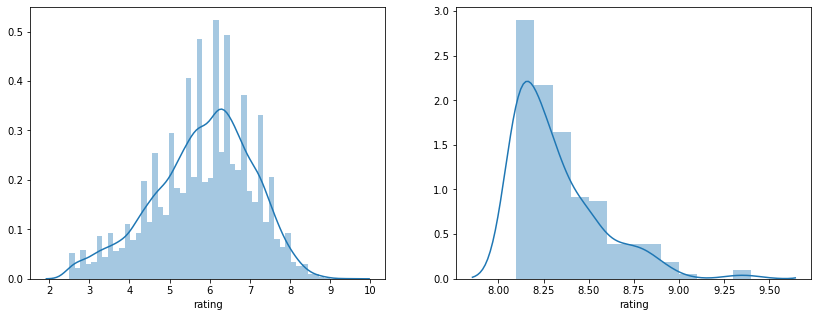

In [2118]:
fig, ax = plt.subplots(ncols = 2, figsize = (14, 5))

sns.distplot(for_regression['rating'], ax = ax[0])
sns.distplot(for_regression[for_regression['rating'] > 8]['rating'], ax = ax[1])

plt.show()

In [2119]:
X = for_regression.copy().drop('rating', 1)
y = for_regression.copy()['rating']

X.shape, y.shape

((12904, 94), (12904,))

StatsModels Multi Lin Reg

In [2120]:
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()

In [2121]:
summary = pd.read_html(results.summary().tables[1].as_html(), header=0, index_col=0)[0]
summary

,coef,std err,t,P>|t|,[0.025,0.975]
const,7.4361,0.114,65.130,0.000,7.212,7.660
Actor Adam Sandler,-0.0946,0.204,-0.463,0.643,-0.495,0.306
Actor Alec Baldwin,0.2242,0.200,1.120,0.263,-0.168,0.617
Actor Anthony Hopkins,0.3944,0.212,1.865,0.062,-0.020,0.809
Actor Arnold Schwarzenegger,0.0054,0.229,0.024,0.981,-0.444,0.455
...,...,...,...,...,...,...
Director Spike Jonze,0.4865,0.515,0.944,0.345,-0.523,1.497
Director Taika Waititi,0.5486,0.470,1.168,0.243,-0.372,1.469
Director Taylor Hackford,-0.2588,0.388,-0.667,0.505,-1.019,0.501
Director Tom Hooper,-0.3368,0.512,-0.658,0.511,-1.341,0.667


Check overall most + and most - coefficients

In [2123]:
print('Crew contributing most negativity to IMDb rating')
print('\nOthers are at the bottom, meaning selected cast and crew are amongst the best in the business')

summary.sort_values('coef').head(10)

Crew contributing most negativity to IMDb rating

Others are at the bottom, meaning selected cast and crew are amongst the best in the business


,coef,std err,t,P>|t|,[0.025,0.975]
Actor Steven Seagal,-1.7008,0.230,-7.379,0.000,-2.153,-1.249
Actor Eric Roberts,-1.3962,0.206,-6.768,0.000,-1.801,-0.992
Actor Danny Trejo,-1.3500,0.224,-6.026,0.000,-1.789,-0.911
Actor Dolph Lundgren,-1.2786,0.209,-6.126,0.000,-1.688,-0.869
Director Other,-1.2239,0.078,-15.606,0.000,-1.378,-1.070
Actor Jean-Claude Van Damme,-0.6655,0.215,-3.094,0.002,-1.087,-0.244
Actor Other,-0.4993,0.090,-5.538,0.000,-0.676,-0.323
Actor Nicolas Cage,-0.4505,0.159,-2.837,0.005,-0.762,-0.139
Actor James Franco,-0.4324,0.202,-2.142,0.032,-0.828,-0.037
Actor John Travolta,-0.3487,0.201,-1.731,0.083,-0.744,0.046


In [2126]:
print('Crew contributing most positivity to IMDb rating')
print('\nChristopher Nolan, Peter Jackson influence the IMDb ratings towards positive the most, amongst actors Denzel Washington and Tom Hanks make the highest rated movies on average')

summary.sort_values('coef', ascending = False).head(10)

Crew contributing most positivity to IMDb rating

Christopher Nolan, Peter Jackson influence the IMDb ratings towards positive the most, amongst actors Denzel Washington and Tom Hanks make the highest rated movies on average


,coef,std err,t,P>|t|,[0.025,0.975]
const,7.4361,0.114,65.130,0.000,7.212,7.660
Director Christopher Nolan,1.1000,0.387,2.839,0.005,0.341,1.859
Director Peter Jackson,0.8017,0.336,2.384,0.017,0.143,1.461
Actor Denzel Washington,0.6784,0.200,3.398,0.001,0.287,1.070
Actor Tom Hanks,0.6313,0.186,3.402,0.001,0.268,0.995
Director Paul Dugdale,0.6032,0.512,1.178,0.239,-0.401,1.607
Actor Kevin Costner,0.5760,0.207,2.781,0.005,0.170,0.982
Actor Brad Pitt,0.5690,0.210,2.714,0.007,0.158,0.980
Actor Johnny Depp,0.5628,0.193,2.914,0.004,0.184,0.941
Actor Matt Damon,0.5510,0.200,2.751,0.006,0.158,0.944


Check significant features

In [2139]:
summary['significance'] = summary['P>|t|'].apply(lambda x: 'significant' if x < 0.05 else 'not significant')

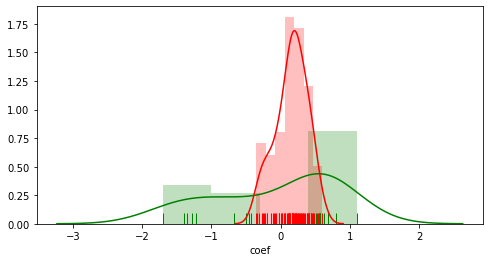

In [2143]:
plt.figure(figsize = (8, 4))
sns.distplot(summary[(summary['coef'] < 2) & (summary['significance'] == 'significant')]['coef'], rug = True, color = 'green', hist_kws={"alpha": 0.25})
sns.distplot(summary[(summary['coef'] < 2) & (summary['significance'] == 'not significant')]['coef'], rug = True, color = 'red', hist_kws={"alpha": 0.25})
plt.show()

In [2145]:
summary[summary['significance'] == 'significant'].sort_values('coef', ascending = False).head(10)

,coef,std err,t,P>|t|,[0.025,0.975],significance
const,7.4361,0.114,65.130,0.000,7.212,7.660,significant
Director Christopher Nolan,1.1000,0.387,2.839,0.005,0.341,1.859,significant
Director Peter Jackson,0.8017,0.336,2.384,0.017,0.143,1.461,significant
Actor Denzel Washington,0.6784,0.200,3.398,0.001,0.287,1.070,significant
Actor Tom Hanks,0.6313,0.186,3.402,0.001,0.268,0.995,significant
Actor Kevin Costner,0.5760,0.207,2.781,0.005,0.170,0.982,significant
Actor Brad Pitt,0.5690,0.210,2.714,0.007,0.158,0.980,significant
Actor Johnny Depp,0.5628,0.193,2.914,0.004,0.184,0.941,significant
Actor Matt Damon,0.5510,0.200,2.751,0.006,0.158,0.944,significant
Actor Tom Cruise,0.5248,0.216,2.429,0.015,0.101,0.948,significant


In [2146]:
summary[summary['significance'] == 'significant'].sort_values('coef').head(10)

,coef,std err,t,P>|t|,[0.025,0.975],significance
Actor Steven Seagal,-1.7008,0.230,-7.379,0.000,-2.153,-1.249,significant
Actor Eric Roberts,-1.3962,0.206,-6.768,0.000,-1.801,-0.992,significant
Actor Danny Trejo,-1.3500,0.224,-6.026,0.000,-1.789,-0.911,significant
Actor Dolph Lundgren,-1.2786,0.209,-6.126,0.000,-1.688,-0.869,significant
Director Other,-1.2239,0.078,-15.606,0.000,-1.378,-1.070,significant
Actor Jean-Claude Van Damme,-0.6655,0.215,-3.094,0.002,-1.087,-0.244,significant
Actor Other,-0.4993,0.090,-5.538,0.000,-0.676,-0.323,significant
Actor Nicolas Cage,-0.4505,0.159,-2.837,0.005,-0.762,-0.139,significant
Actor James Franco,-0.4324,0.202,-2.142,0.032,-0.828,-0.037,significant
Actor Jeff Bridges,0.4349,0.217,2.008,0.045,0.010,0.859,significant


Evaluate regression model

In [2148]:
results.summary().tables[0]

Dep. Variable:,rating,R-squared:,0.091
Model:,OLS,Adj. R-squared:,0.084
Method:,Least Squares,F-statistic:,13.89
Date:,"Tue, 08 Sep 2020",Prob (F-statistic):,8.27e-197
Time:,19:36:09,Log-Likelihood:,-20296.
No. Observations:,12904,AIC:,4.078e+04
Df Residuals:,12811,BIC:,4.147e+04
Df Model:,92,,
Covariance Type:,nonrobust,,


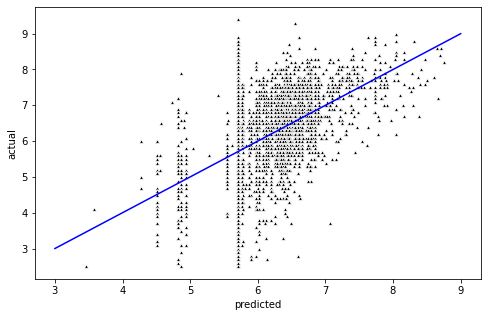

In [2168]:
prediction = pd.concat([results.predict(X), y], 1, keys = ['predicted', 'actual'])

plt.figure(figsize = (8, 5))
sns.scatterplot(x = 'predicted', y = 'actual', data = prediction, s = 15, marker = '^', color = 'black')
sns.lineplot(x = [3, 9], y = [3, 9], color = 'blue')
plt.show()

#### Adding genres as X variables

In [2277]:
for_regression_with_genres = data.copy()

In [2278]:
for_regression_with_genres = for_regression_with_genres[for_regression_with_genres['genres'].notnull()]
for_regression_with_genres['genres'] = for_regression_with_genres['genres'].apply(lambda x: ast.literal_eval(x))

In [2279]:
for_regression_with_genres = pd.concat([for_regression_with_genres, pd.get_dummies(for_regression_with_genres.genres.apply(pd.Series).stack(), prefix = 'Genre', prefix_sep = ' ').sum(level=0)], 1)
for_regression_with_genres.drop(['genres', 'year', 'budget', 'revenue', 'roi'], 1, inplace = True)
for_regression_with_genres.set_index('title', inplace = True)
for_regression_with_genres.head()

,rating,Actor Adam Sandler,Actor Alec Baldwin,Actor Anthony Hopkins,Actor Arnold Schwarzenegger,Actor Ben Kingsley,Actor Ben Stiller,Actor Brad Pitt,Actor Bruce Willis,Actor Cate Blanchett,Actor Charlize Theron,Actor Colin Farrell,Actor Danny Glover,Actor Danny Trejo,Actor Dennis Quaid,Actor Denzel Washington,Actor Dolph Lundgren,Actor Ed Harris,Actor Eddie Murphy,Actor Eric Roberts,Actor Ethan Hawke,Actor Ewan McGregor,Actor Forest Whitaker,Actor Gary Oldman,Actor George Clooney,Actor Harrison Ford,Actor James Franco,Actor Jason Statham,Actor Jean-Claude Van Damme,Actor Jeff Bridges,Actor John Cusack,Actor John Goodman,Actor John Travolta,Actor Johnny Depp,Actor Julia Roberts,Actor Julianne Moore,Actor Keanu Reeves,Actor Kevin Costner,Actor Kurt Russell,Actor Liam Neeson,Actor Mark Wahlberg,Actor Matt Damon,Actor Matthew McConaughey,Actor Mel Gibson,Actor Meryl Streep,Actor Michelle Pfeiffer,Actor Morgan Freeman,Actor Nicolas Cage,Actor Nicole Kidman,Actor Other,Actor Owen Wilson,Actor Pierce Brosnan,Actor Robert De Niro,Actor Robert Downey Jr.,Actor Robin Williams,Actor Samuel L. Jackson,Actor Steven Seagal,Actor Sylvester Stallone,Actor Tom Cruise,Actor Tom Hanks,Actor Tommy Lee Jones,Actor Val Kilmer,Actor Willem Dafoe,Actor Woody Harrelson,Director Alfonso Cuarón,Director Anthony Russo,Director Brad Bird,Director Christopher Nolan,Director Darren Aronofsky,Director David Fincher,Director David Lynch,Director David Yates,Director Denis Villeneuve,Director Edgar Wright,Director Guy Ritchie,Director James Cameron,Director Jim Jarmusch,Director Joe Russo,Director Joel Coen,Director Martin Scorsese,Director Matthew Vaughn,Director Mel Gibson,Director Michael Moore,Director Mike Leigh,Director Other,Director Paul Dugdale,Director Paul Greengrass,Director Peter Jackson,Director Quentin Tarantino,Director Sam Mendes,Director Spike Jonze,Director Taika Waititi,Director Taylor Hackford,Director Tom Hooper,Director Wes Anderson,Genre Action,Genre Adventure,Genre Animation,Genre Biography,Genre Comedy,Genre Crime,Genre Documentary,Genre Drama,Genre Family,Genre Fantasy,Genre Game-Show,Genre History,Genre Horror,Genre Music,Genre Musical,Genre Mystery,Genre News,Genre Reality-TV,Genre Romance,Genre Sci-Fi,Genre Sport,Genre Talk-Show,Genre Thriller,Genre War,Genre Western
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Memoirs of an Invisible Man,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0
Barbie Princess Adventure,7.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Feels Good Man,7.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Beautiful & Twisted,5.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Battle Mountain: Graeme Obree's Story,7.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [2280]:
X = for_regression_with_genres.copy().drop('rating', 1)
y = for_regression_with_genres.copy()['rating']

X.shape, y.shape

((12903, 119), (12903,))

In [2281]:
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()

In [2282]:
summary = pd.read_html(results.summary().tables[1].as_html(), header=0, index_col=0)[0]
summary['significance'] = summary['P>|t|'].apply(lambda x: 'significant' if x < 0.05 else 'not significant')
summary

,coef,std err,t,P>|t|,[0.025,0.975],significance
const,6.4018,0.102,62.582,0.000,6.201,6.602,significant
Actor Adam Sandler,-0.0144,0.176,-0.082,0.935,-0.359,0.331,not significant
Actor Alec Baldwin,0.0568,0.172,0.330,0.741,-0.280,0.394,not significant
Actor Anthony Hopkins,0.2732,0.182,1.502,0.133,-0.083,0.630,not significant
Actor Arnold Schwarzenegger,0.2617,0.197,1.326,0.185,-0.125,0.649,not significant
...,...,...,...,...,...,...,...
Genre Sport,0.3149,0.051,6.168,0.000,0.215,0.415,significant
Genre Talk-Show,-0.1271,1.508,-0.084,0.933,-3.084,2.829,not significant
Genre Thriller,-0.0852,0.024,-3.566,0.000,-0.132,-0.038,significant
Genre War,0.2039,0.054,3.798,0.000,0.099,0.309,significant


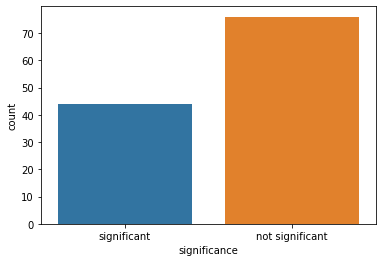

In [2285]:
sns.countplot(summary['significance'])

In [2283]:
summary[summary['significance'] == 'significant'].sort_values('coef', ascending = False).head(10)

,coef,std err,t,P>|t|,[0.025,0.975],significance
const,6.4018,0.102,62.582,0.000,6.201,6.602,significant
Genre Documentary,1.5769,0.044,35.813,0.000,1.491,1.663,significant
Director Christopher Nolan,1.2306,0.333,3.695,0.000,0.578,1.883,significant
Director Peter Jackson,0.8040,0.290,2.777,0.005,0.237,1.372,significant
Director Quentin Tarantino,0.7679,0.308,2.489,0.013,0.163,1.373,significant
Genre Biography,0.5821,0.041,14.228,0.000,0.502,0.662,significant
Actor Denzel Washington,0.5589,0.172,3.256,0.001,0.222,0.895,significant
Actor Tom Cruise,0.5523,0.186,2.970,0.003,0.188,0.917,significant
Genre Animation,0.5456,0.052,10.505,0.000,0.444,0.647,significant
Actor Kurt Russell,0.5394,0.195,2.765,0.006,0.157,0.922,significant


In [2284]:
summary[summary['significance'] == 'significant'].sort_values('coef').head(10)

,coef,std err,t,P>|t|,[0.025,0.975],significance
Director Tom Hooper,-1.4840,0.493,-3.013,0.003,-2.450,-0.518,significant
Actor Steven Seagal,-1.3663,0.199,-6.881,0.000,-1.755,-0.977,significant
Director Other,-1.0104,0.068,-14.859,0.000,-1.144,-0.877,significant
Actor Danny Trejo,-0.9564,0.193,-4.964,0.000,-1.334,-0.579,significant
Actor Dolph Lundgren,-0.9489,0.179,-5.287,0.000,-1.301,-0.597,significant
Actor Eric Roberts,-0.8642,0.177,-4.870,0.000,-1.212,-0.516,significant
Genre Horror,-0.5058,0.027,-19.068,0.000,-0.558,-0.454,significant
Actor James Franco,-0.4857,0.173,-2.800,0.005,-0.826,-0.146,significant
Actor Jean-Claude Van Damme,-0.4487,0.185,-2.425,0.015,-0.811,-0.086,significant
Actor John Travolta,-0.3522,0.173,-2.034,0.042,-0.692,-0.013,significant


In [2286]:
results.summary().tables[0]

Dep. Variable:,rating,R-squared:,0.332
Model:,OLS,Adj. R-squared:,0.325
Method:,Least Squares,F-statistic:,54.20
Date:,"Tue, 08 Sep 2020",Prob (F-statistic):,0.00
Time:,20:19:48,Log-Likelihood:,-18309.
No. Observations:,12903,AIC:,3.685e+04
Df Residuals:,12785,BIC:,3.774e+04
Df Model:,117,,
Covariance Type:,nonrobust,,


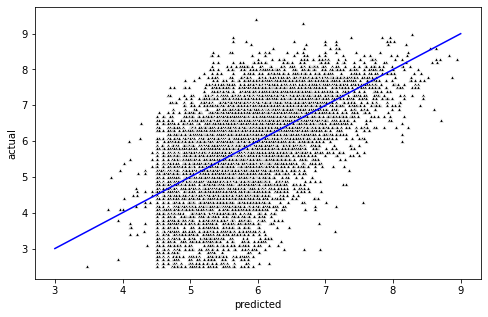

In [2287]:
prediction = pd.concat([results.predict(X), y], 1, keys = ['predicted', 'actual'])

plt.figure(figsize = (8, 5))
sns.scatterplot(x = 'predicted', y = 'actual', data = prediction, s = 15, marker = '^', color = 'black')
sns.lineplot(x = [3, 9], y = [3, 9], color = 'blue')
plt.show()

Genres' effect

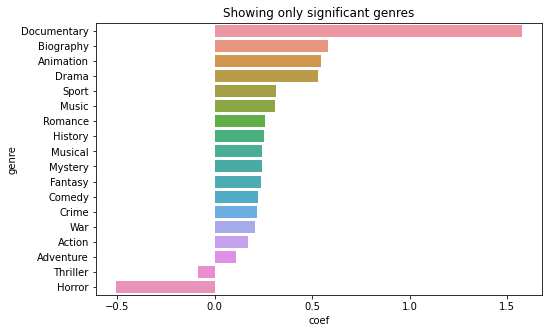

In [2312]:
genre_results = summary[(summary.index.str.contains('Genre')) & (summary['significance'] == 'significant')].sort_values('coef', ascending = False)
genre_results['genre'] = genre_results.index
genre_results.reset_index(drop = True, inplace = True)
genre_results['genre'] = genre_results['genre'].str.replace('Genre ', '')

plt.figure(figsize = (8, 5))
sns.barplot(x = 'coef', y = 'genre', data = genre_results)
plt.title('Showing only significant genres')
plt.show()

Actors' effect

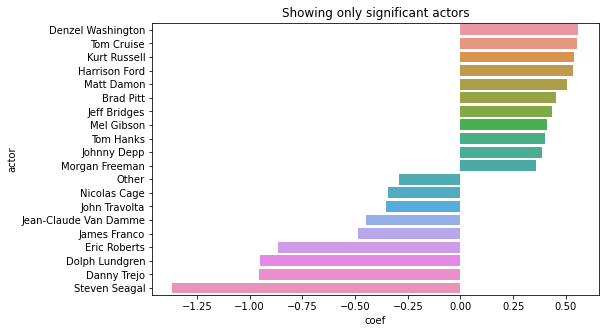

In [2311]:
actors_results = summary[(summary.index.str.contains('Actor')) & (summary['significance'] == 'significant')].sort_values('coef', ascending = False)
actors_results['actor'] = actors_results.index
actors_results.reset_index(drop = True, inplace = True)
actors_results['actor'] = actors_results['actor'].str.replace('Actor ', '')

plt.figure(figsize = (8, 5))
sns.barplot(x = 'coef', y = 'actor', data = actors_results)
plt.title('Showing only significant actors')
plt.show()

Directors' effect

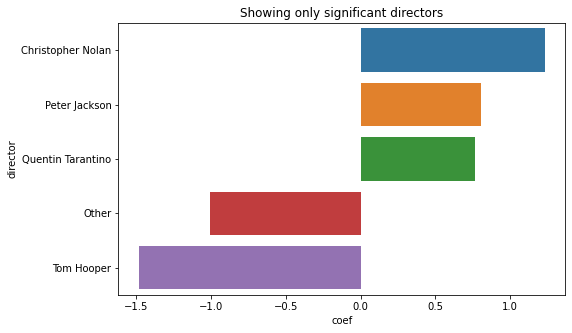

In [2313]:
directors_results = summary[(summary.index.str.contains('Director')) & (summary['significance'] == 'significant')].sort_values('coef', ascending = False)
directors_results['director'] = directors_results.index
directors_results.reset_index(drop = True, inplace = True)
directors_results['director'] = directors_results['director'].str.replace('Director ', '')

plt.figure(figsize = (8, 5))
sns.barplot(x = 'coef', y = 'director', data = directors_results)
plt.title('Showing only significant directors')
plt.show()

#### Build regression tree to better see interactions

In [2328]:
X = for_regression_with_genres.copy().drop('rating', 1)
#X = X[X.columns].apply(pd.to_numeric)
y = for_regression_with_genres.copy()['rating']

X.shape, y.shape

((12903, 119), (12903,))

In [2344]:
classifier = DecisionTreeRegressor(random_state = 20202020, max_depth = 6, min_samples_split = 1000)
classifier.fit(X, y)

DecisionTreeRegressor(max_depth=5, min_samples_split=1000,
                      random_state=20202020)

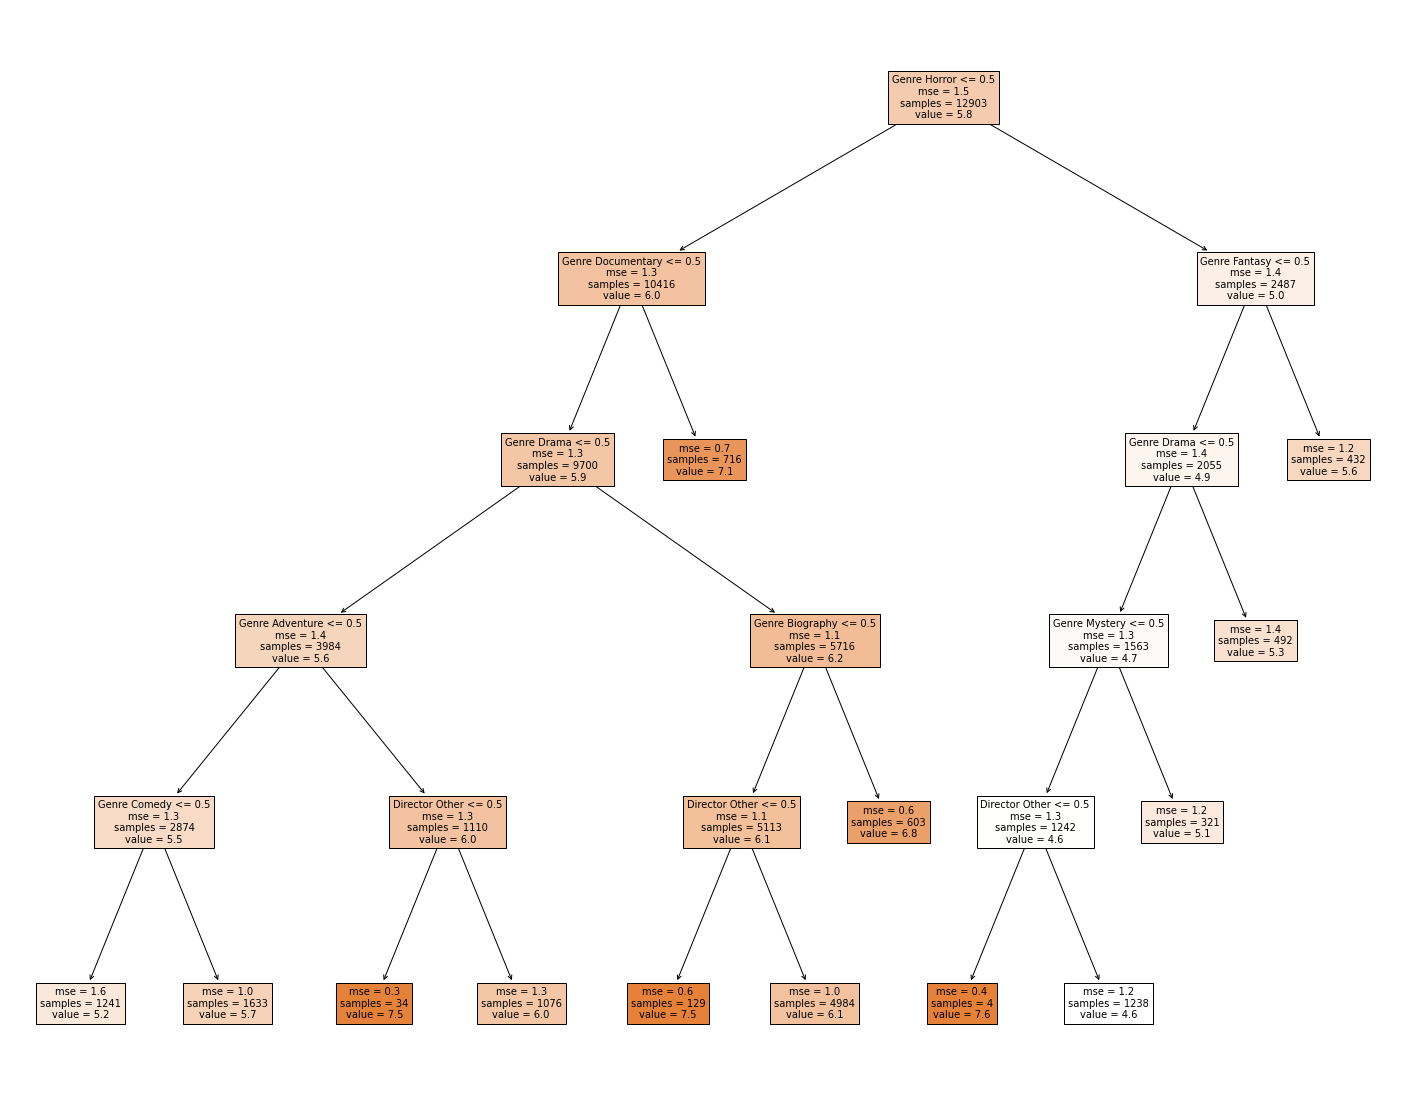

In [2348]:
plt.figure(figsize=(25, 20))
plot_tree(classifier, feature_names = X.columns, filled = True, max_depth = 6, precision = 1)
plt.show()

Seems like mostly the genre holds the variation, or if the director is 'other' (= not amongst the best). Reasonable, as actors and directors cannot influence variation by that much.

### Genre association

In [2379]:
GA = for_regression_with_genres.filter(regex = 'Genre')
GA.columns = GA.columns.str.replace('Genre ', '')

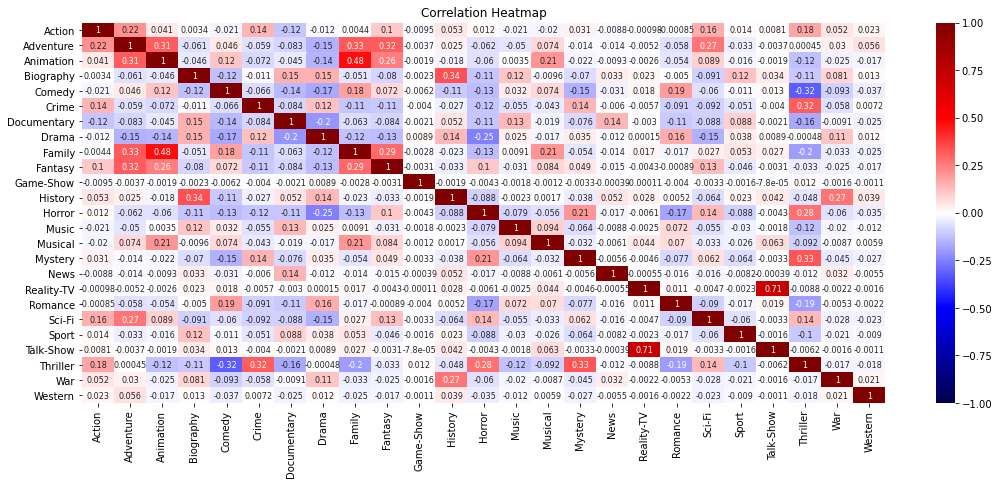

In [2380]:
plt.figure(figsize=(18, 7))
sns.heatmap(GA.corr(), vmin=-1, vmax=1, annot = True, cmap='seismic', annot_kws={"size": 8})
plt.title('Correlation Heatmap')
plt.show()

High correls: realtytv-talkshow, family-animation, mystery-thriller

Low correls: comedy-thriller, horror-drama, drama-doc

Cramer's V

In [2392]:
def cramers_V(a, b):
    
    crosstab = array(pd.crosstab(a, b, rownames = None, colnames = None)) 
    stat = chi2_contingency(crosstab)[0] 
    
    obs = sum(crosstab) 
    mini = min(crosstab.shape) - 1  
    
    return (stat/(obs*mini))

In [2395]:
rows= []

for col1 in GA:
    col = []
    for col2 in GA:
        cramers = cramers_V(GA[col1], GA[col2])
        col.append(round(cramers, 2))
    rows.append(col)
        
cramers_results = array(rows)
categorical_association_table = pd.DataFrame(cramers_results, columns = GA.columns, index = GA.columns)

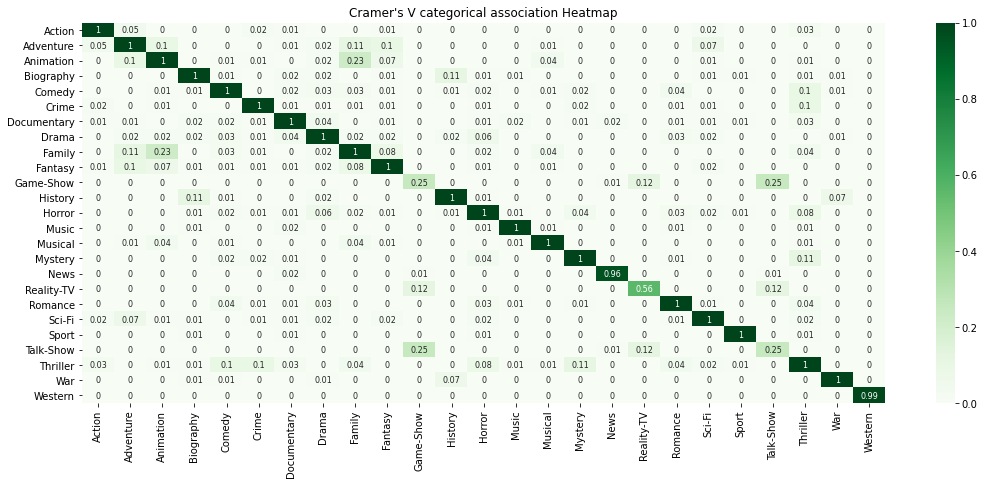

In [2398]:
plt.figure(figsize=(18, 7))
sns.heatmap(categorical_association_table, vmin=0, vmax=1, annot = True, cmap='Greens', annot_kws={"size": 8})
plt.title("Cramer's V categorical association Heatmap")
plt.show()

### Actor association

In [2400]:
AA = for_regression_with_genres.filter(regex = 'Actor')
AA.columns = AA.columns.str.replace('Actor ', '')

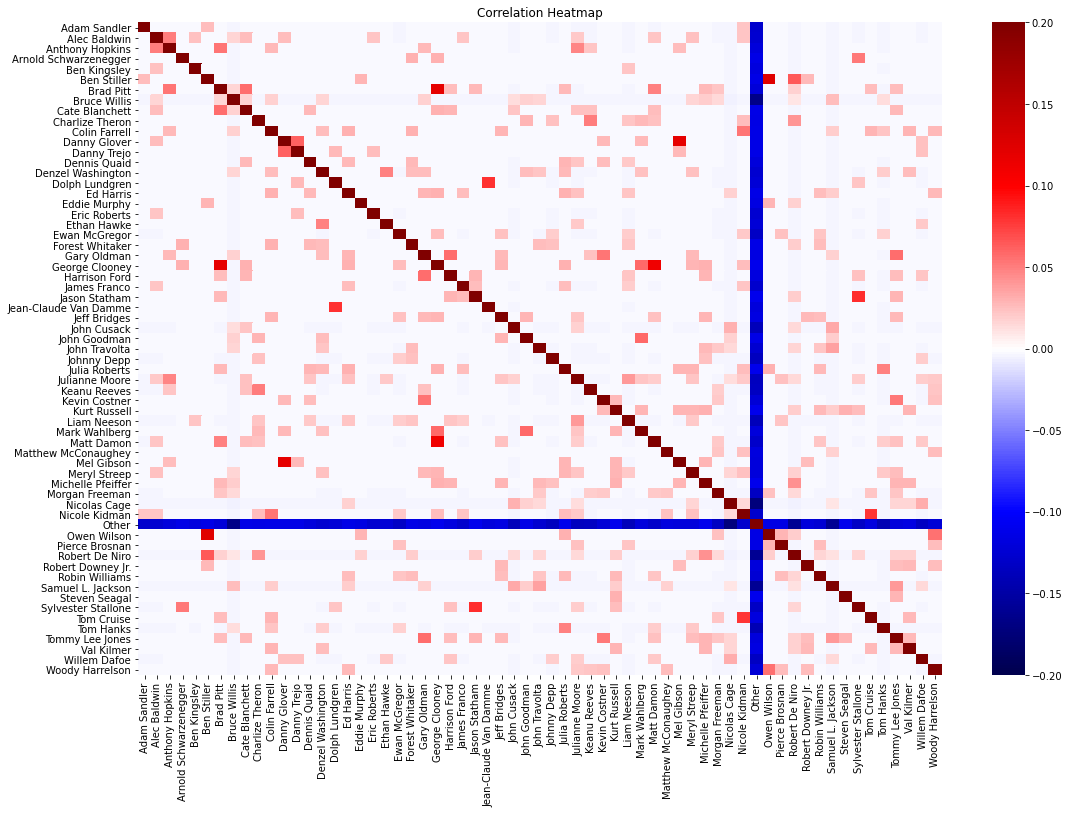

In [2440]:
plt.figure(figsize=(18, 12))
sns.heatmap(AA.corr(), vmin=-0.2, vmax=0.2, annot = False, cmap='seismic') #annot_kws={"size": 8})
plt.title('Correlation Heatmap')
plt.show()

In [2439]:
cor_pairs = AA.corr().unstack().sort_values(ascending = False)
cor_pairs = cor_pairs[cor_pairs != 1].drop_duplicates()
cor_pairs[(~cor_pairs.index.get_level_values(0).isin(['Other'])) & (~cor_pairs.index.get_level_values(1).isin(['Other']))].head(10)

Ben Stiller            Owen Wilson           0.124864
George Clooney         Brad Pitt             0.119475
Danny Glover           Mel Gibson            0.119187
George Clooney         Matt Damon            0.111642
Jason Statham          Sylvester Stallone    0.081993
Jean-Claude Van Damme  Dolph Lundgren        0.080802
Nicole Kidman          Tom Cruise            0.078717
Robert De Niro         Ben Stiller           0.065267
Danny Trejo            Danny Glover          0.062263
Mark Wahlberg          George Clooney        0.059360
dtype: float64

Not needed anymore:

x['director_main'] = x['directors'].apply(lambda x: x[0] if (x != []) else float('nan'))
x['director_sec'] = x['directors'].apply(lambda x: x[1] if (x != [] and len(x) > 1) else float('nan'))

x.drop('directors', 1, inplace = True)

x['actor_main'] = x['lead_actors'].apply(lambda x: x[0] if (x != []) else float('nan'))
x['actor_sec'] = x['lead_actors'].apply(lambda x: x[1] if (x != [] and len(x) > 1) else float('nan'))
x['actor_thi'] = x['lead_actors'].apply(lambda x: x[2] if (x != [] and len(x) > 2) else float('nan'))

x.drop('lead_actors', 1, inplace = True)

x['writer_main'] = x['writers'].apply(lambda x: x[0] if (x != [] ) else float('nan'))
x['writer_sec'] = x['writers'].apply(lambda x: x[1] if (x != [] and len(x) > 1) else float('nan'))

x.drop('writers', 1, inplace = True)

x['budget'] = x['budget'].apply(lambda x: re.sub('[^0-9.]','', x.split()[0]) if (isinstance(x, float) is False) else float('nan'))

x['open_we'] = x['open_we'].apply(lambda x: re.sub('[^0-9.]','', x.split()[0]) if (isinstance(x, float) is False) else float('nan'))

x['ww_gross'] = x['ww_gross'].apply(lambda x: re.sub('[^0-9.]','', x.split()[0]) if (isinstance(x, float) is False) else float('nan'))